In [1]:
import os

if "TRANSFORMERS_CACHE" in os.environ:
    print(f"Removing existing TRANSFORMERS_CACHE: {os.environ['TRANSFORMERS_CACHE']}")
    del os.environ["TRANSFORMERS_CACHE"]

os.environ["HF_HOME"] = os.path.join(os.getcwd(), ".hf_cache")
print(f"HF_HOME: {os.getenv('HF_HOME')}")

Removing existing TRANSFORMERS_CACHE: /storage/coda1/p-dsgt_clef2025/0/kthakrar3/hf_cache
HF_HOME: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/.hf_cache


In [2]:
import sys
import gc
import re
import ast
import json
import shutil
import random
import pickle
import datetime
import traceback
import glob
from collections import Counter, defaultdict
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig, MllamaForConditionalGeneration, AutoModelForVision2Seq, Qwen2VLForConditionalGeneration, Qwen2_5_VLForConditionalGeneration, AutoTokenizer

from peft import LoraConfig, PeftModel
from trl import SFTConfig, SFTTrainer

from tensorboard.backend.event_processing import event_accumulator

from dotenv import load_dotenv
import zipfile
import requests

from qwen_vl_utils import process_vision_info

In [3]:
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

gc.collect()
torch.cuda.empty_cache()

Python version: 3.10.10 (main, Apr 15 2024, 11:52:16) [GCC 11.4.1 20230605 (Red Hat 11.4.1-2)]
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA H100 80GB HBM3


In [4]:
load_dotenv()

AVAILABLE_MODELS = {
    "llama-3.2-11b-vision": "meta-llama/Llama-3.2-11B-Vision-Instruct",
    "gemma-3-4b-it": "google/gemma-3-4b-it",
    "gemma-3-12b-it": "google/gemma-3-12b-it",
    "Qwen2-VL-2B-Instruct": "Qwen/Qwen2-VL-2B-Instruct",
    "Qwen2-VL-7B-Instruct": "Qwen/Qwen2-VL-7B-Instruct",
    "Qwen2.5-VL-3B-Instruct": "Qwen/Qwen2.5-VL-3B-Instruct",
    "Qwen2.5-VL-7B-Instruct": "Qwen/Qwen2.5-VL-7B-Instruct"
}

SELECTED_MODEL = "Qwen2.5-VL-7B-Instruct"

BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
DATASET_DIR = os.path.join(BASE_DIR, "2025_dataset")
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "valid")
TEST_DIR = os.path.join(DATASET_DIR, "test")

TRAIN_IMAGES_DIR = os.path.join(TRAIN_DIR, "images_train")
VAL_IMAGES_DIR = os.path.join(VAL_DIR, "images_valid")
TEST_IMAGES_DIR = os.path.join(TEST_DIR, "images_test")

OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

PROCESSED_TRAIN_DATA_DIR = os.path.join(OUTPUT_DIR, f"processed_train_data-{SELECTED_MODEL}-V3")
PROCESSED_VAL_DATA_DIR = os.path.join(OUTPUT_DIR, f"processed_val_data-{SELECTED_MODEL}-V3")
PROCESSED_COMBINED_DATA_DIR = os.path.join(OUTPUT_DIR, f"processed_combined_data-{SELECTED_MODEL}-V3")
PROCESSED_TEST_DATA_DIR = os.path.join(OUTPUT_DIR, f"processed_test_data-{SELECTED_MODEL}-V3")

QUESTIONS_PATH = os.path.join(TRAIN_DIR, "closedquestions_definitions_imageclef2025.json")

TRAIN_JSON_PATH = os.path.join(TRAIN_DIR, "train.json")
VAL_JSON_PATH = os.path.join(VAL_DIR, "valid.json")
TEST_JSON_PATH = os.path.join(TEST_DIR, "test.json")

TRAIN_CVQA_PATH = os.path.join(TRAIN_DIR, "train_cvqa.json")
VAL_CVQA_PATH = os.path.join(VAL_DIR, "valid_cvqa.json")

MODEL_ID = AVAILABLE_MODELS[SELECTED_MODEL]
MODEL_NAME = MODEL_ID.split('/')[-1]
IS_LLAMA = "llama" in MODEL_ID.lower()
IS_QWEN = "qwen" in MODEL_ID.lower()

HF_TOKEN = os.getenv("HF_TOKEN")

TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M")
MODEL_SAVE_DIRECTORY = os.path.join(OUTPUT_DIR, "finetuned-model", f"{MODEL_NAME}_{TIMESTAMP}")
os.makedirs(MODEL_SAVE_DIRECTORY, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Selected model: {SELECTED_MODEL}")
print(f"Model ID: {MODEL_ID}")
print(f"Is Llama model: {IS_LLAMA}")
print(f"Is Qwen model: {IS_QWEN}")
print(f"Model output directory: {MODEL_SAVE_DIRECTORY}")

Base directory: /storage/scratch1/2/kthakrar3/mediqa-magic-v2
Selected model: Qwen2.5-VL-7B-Instruct
Model ID: Qwen/Qwen2.5-VL-7B-Instruct
Is Llama model: False
Is Qwen model: True
Model output directory: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/finetuned-model/Qwen2.5-VL-7B-Instruct_20250501_1804


In [5]:
def get_model_config(torch_dtype=None):
    """Create standardized model configuration dictionary"""
    if torch_dtype is None:
        torch_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32
        
    model_kwargs = dict(
        torch_dtype=torch_dtype,
        device_map="auto" if torch.cuda.is_available() else None
    )
    
    model_kwargs["quantization_config"] = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
        bnb_4bit_quant_storage=model_kwargs["torch_dtype"]
    )
    
    return model_kwargs

if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] < 8:
    print("WARNING: GPU may not fully support bfloat16. Consider using float16 instead.")

model_kwargs = get_model_config(torch_dtype=torch.bfloat16)

if IS_LLAMA:
    model = MllamaForConditionalGeneration.from_pretrained(MODEL_ID, **model_kwargs)
    if hasattr(model, "tie_weights"):
        model.tie_weights()
elif IS_QWEN:
    if "2.5" in MODEL_ID:
        model = Qwen2_5_VLForConditionalGeneration.from_pretrained(MODEL_ID, **model_kwargs)
    else:
        model = Qwen2VLForConditionalGeneration.from_pretrained(MODEL_ID, **model_kwargs)
else:
    non_llama_kwargs = model_kwargs.copy()
    non_llama_kwargs["attn_implementation"] = "eager"
    model = AutoModelForImageTextToText.from_pretrained(MODEL_ID, **non_llama_kwargs)

processor = AutoProcessor.from_pretrained(MODEL_ID, token=HF_TOKEN)

print(f"Default chat template: {processor.tokenizer.chat_template}")
print(f"Special tokens map: {processor.tokenizer.special_tokens_map}")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Default chat template: {% set image_count = namespace(value=0) %}{% set video_count = namespace(value=0) %}{% for message in messages %}{% if loop.first and message['role'] != 'system' %}<|im_start|>system
You are a helpful assistant.<|im_end|>
{% endif %}<|im_start|>{{ message['role'] }}
{% if message['content'] is string %}{{ message['content'] }}<|im_end|>
{% else %}{% for content in message['content'] %}{% if content['type'] == 'image' or 'image' in content or 'image_url' in content %}{% set image_count.value = image_count.value + 1 %}{% if add_vision_id %}Picture {{ image_count.value }}: {% endif %}<|vision_start|><|image_pad|><|vision_end|>{% elif content['type'] == 'video' or 'video' in content %}{% set video_count.value = video_count.value + 1 %}{% if add_vision_id %}Video {{ video_count.value }}: {% endif %}<|vision_start|><|video_pad|><|vision_end|>{% elif 'text' in content %}{{ content['text'] }}{% endif %}{% endfor %}<|im_end|>
{% endif %}{% endfor %}{% if add_generation_pr

In [6]:
def merge_lora_model(checkpoint_path=None, token=None, output_dir=None):
    """Merge LoRA weights into base model and save to output directory"""
    if checkpoint_path is None:
        checkpoint_pattern = os.path.join(OUTPUT_DIR, "finetuned-model", f"{MODEL_NAME}_*", "checkpoint-*")
        checkpoint_dirs = glob.glob(checkpoint_pattern)
        
        if not checkpoint_dirs:
            raise FileNotFoundError(f"No checkpoints found matching pattern {checkpoint_pattern}")
            
        checkpoint_dirs = sorted(checkpoint_dirs,
                                key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)),
                                reverse=True)
        checkpoint_path = checkpoint_dirs[0]
        print(f"Using latest checkpoint: {checkpoint_path}")
        
    if output_dir is None:
        checkpoint_name = os.path.basename(checkpoint_path)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
        output_dir = os.path.join(OUTPUT_DIR, "merged", f"{MODEL_NAME}_{checkpoint_name}_{timestamp}")
        
    model_kwargs = get_model_config(torch_dtype=torch.bfloat16)
    
    if IS_LLAMA:
        model = MllamaForConditionalGeneration.from_pretrained(
            MODEL_ID,
            low_cpu_mem_usage=True,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            token=token
        )
    elif IS_QWEN:
        if "2.5" in MODEL_ID:
            model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
                MODEL_ID,
                low_cpu_mem_usage=True,
                **model_kwargs,
                token=token
            )
        else:
            model = Qwen2VLForConditionalGeneration.from_pretrained(
                MODEL_ID,
                low_cpu_mem_usage=True,
                **model_kwargs,
                token=token
            )
    else:
        
        non_llama_kwargs = model_kwargs.copy()
        non_llama_kwargs["attn_implementation"] = "eager"
        model = AutoModelForImageTextToText.from_pretrained(
            MODEL_ID,
            low_cpu_mem_usage=True,
            **non_llama_kwargs,
            token=token
        )
        
    print(f"Applying adapter from {checkpoint_path}...")
    peft_model = PeftModel.from_pretrained(model, checkpoint_path)
    print("Merging weights...")
    merged_model = peft_model.merge_and_unload()
    
    os.makedirs(output_dir, exist_ok=True)
    print(f"Saving merged model to {output_dir}...")
    merged_model.save_pretrained(output_dir, safe_serialization=True, max_shard_size="2GB")
    
    processor = AutoProcessor.from_pretrained(MODEL_ID, token=token)
    processor.save_pretrained(output_dir)
    
    del model
    del peft_model
    del merged_model
    torch.cuda.empty_cache()
    print(f"Merged model saved to {output_dir}")
    return output_dir

In [7]:
class Args:
    def __init__(self, use_finetuning=True):
        """
        Initialize inference arguments with options for finetuning.
        
        Parameters:
        - use_finetuning: Whether to use the fine-tuned model (True) or base model (False)
        """
        self.test = False
        self.skip_data_prep = False
        self.batch_size = 100
        self.max_samples = None
        self.use_finetuning = use_finetuning
        self.use_combined_dataset = False
        self.min_data_size = 10
        
        if self.use_finetuning:
            checkpoint_pattern = os.path.join(OUTPUT_DIR, "finetuned-model", f"{MODEL_NAME}_*", "checkpoint-*")
            checkpoint_dirs = glob.glob(checkpoint_pattern)
            
            if not checkpoint_dirs:
                raise FileNotFoundError(f"No checkpoints found for model {MODEL_NAME}")
            
            checkpoint_dirs = sorted(checkpoint_dirs, 
                                    key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)), 
                                    reverse=True)
            
            checkpoint_path = checkpoint_dirs[0]
            print(f"Creating merged model from latest checkpoint: {checkpoint_path}")
            
            checkpoint_name = os.path.basename(checkpoint_path)
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
            merged_dir = os.path.join(OUTPUT_DIR, "merged", f"{MODEL_NAME}_{checkpoint_name}_{timestamp}")
            
            self.model_path = merge_lora_model(
                checkpoint_path=checkpoint_path,
                token=HF_TOKEN,
                output_dir=merged_dir
            )
            print(f"Using merged model at {self.model_path}")
            
            self.adapter_path = None
        else:
            self.model_path = MODEL_ID
            self.adapter_path = None
            print(f"Using BASE MODEL ONLY at {self.model_path} (no fine-tuning applied)")
        
        print("\nModel for inference:", "FINE-TUNED" if self.use_finetuning else "BASE MODEL (NO FINE-TUNING)")
        
args = Args()

Creating merged model from latest checkpoint: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/finetuned-model/Qwen2.5-VL-7B-Instruct_20250428_0636/checkpoint-738


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Applying adapter from /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/finetuned-model/Qwen2.5-VL-7B-Instruct_20250428_0636/checkpoint-738...
Merging weights...


/storage/scratch1/2/kthakrar3/mediqa-magic-v2/.venv/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:355: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Saving merged model to /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/merged/Qwen2.5-VL-7B-Instruct_checkpoint-738_20250501_1805...
Merged model saved to /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/merged/Qwen2.5-VL-7B-Instruct_checkpoint-738_20250501_1805
Using merged model at /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/merged/Qwen2.5-VL-7B-Instruct_checkpoint-738_20250501_1805

Model for inference: FINE-TUNED


In [8]:
def safe_convert_options(options_str):
    """
    Safely convert a string representation of a list to an actual list.
    """
    if not isinstance(options_str, str):
        return options_str
        
    try:
        return ast.literal_eval(options_str)
    except (SyntaxError, ValueError):
        if options_str.startswith('[') and options_str.endswith(']'):
            return [opt.strip().strip("'\"") for opt in options_str[1:-1].split(',')]
        elif ',' in options_str:
            return [opt.strip() for opt in options_str.split(',')]
        else:
            return [options_str]

In [ ]:
def prepare_dataset(mode="train"):
    """
    Create a dataset for either training or validation data.
    
    Args:
        mode: Either "train" or "val" to specify which dataset to prepare
    
    Returns:
        DataFrame containing the processed dataset
    """
    print(f"Preparing {mode} dataset...")
    
    if mode == "train":
        json_path = TRAIN_JSON_PATH
        cvqa_path = TRAIN_CVQA_PATH
        images_dir = TRAIN_IMAGES_DIR
        output_filename = "train_dataset_processed.csv"
    elif mode == "val":
        json_path = VAL_JSON_PATH
        cvqa_path = VAL_CVQA_PATH
        images_dir = VAL_IMAGES_DIR
        output_filename = "val_dataset.csv"
    else:
        raise ValueError("Mode must be either 'train' or 'val'")
    
    with open(QUESTIONS_PATH, 'r') as f:
        questions = json.load(f)
        
    questions_df = pd.json_normalize(questions)[["qid", "question_en", "options_en", "question_type_en", "question_category_en"]]
    
    input_df = pd.read_json(json_path)
    
    query_info_df = input_df[["encounter_id", "image_ids", "query_title_en", "query_content_en", "author_id"]]
    
    with open(cvqa_path, 'r') as f:
        cvqa_data = json.load(f)
    cvqa_df = pd.json_normalize(cvqa_data)
    
    cvqa_long = cvqa_df.melt(id_vars=["encounter_id"], 
                             var_name="qid", 
                             value_name="answer_index")
    
    cvqa_long = cvqa_long[cvqa_long["qid"] != "encounter_id"]
    
    cvqa_merged = cvqa_long.merge(questions_df, on="qid", how="left")
    
    def get_answer_text(row):
        try:
            return row["options_en"][row["answer_index"]]
        except (IndexError, TypeError):
            return None
    
    cvqa_merged["answer_text"] = cvqa_merged.apply(get_answer_text, axis=1)
    
    final_df = cvqa_merged.merge(query_info_df, on="encounter_id", how="left")
    
    final_df['base_qid'] = final_df['qid'].str.extract(r'(CQID\d+)')
    
    grouped_by_family = final_df.groupby(['encounter_id', 'base_qid']).agg({
        'qid': list,
        'question_en': list,
        'answer_text': list,
        'answer_index': list,
        'image_ids': 'first',
        'options_en': 'first',
        'question_type_en': 'first',
        'question_category_en': 'first',
        'query_title_en': 'first',
        'query_content_en': 'first',
        'author_id': 'first'
    })
    
    grouped_by_family = grouped_by_family.reset_index()
    
    def get_valid_answers(row):
        """
        Extract all valid answers, with special handling for "Not mentioned".
        If "Not mentioned" is the only answer for all slots, we keep it.
        Otherwise, we collect all non-"Not mentioned" answers.
        """
        answers = row['answer_text']
        answer_indices = row['answer_index']

        if all(ans == "Not mentioned" for ans in answers):
            return ["Not mentioned"], [answer_indices[0]]

        valid_answers = []
        valid_indices = []

        for i, ans in enumerate(answers):
            if ans != "Not mentioned":
                if isinstance(ans, str):
                    cleaned_ans = ans.strip("'\" ").replace(" (please specify)", "")
                    if cleaned_ans not in valid_answers:
                        valid_answers.append(cleaned_ans)
                        valid_indices.append(answer_indices[i])
                else:
                    str_ans = str(ans).strip("'\" ")
                    if str_ans not in valid_answers:
                        valid_answers.append(str_ans)
                        valid_indices.append(answer_indices[i])

        return valid_answers, valid_indices
    
    grouped_by_family[['valid_answers', 'valid_indices']] = grouped_by_family.apply(
        lambda row: pd.Series(get_valid_answers(row)), axis=1)
    
    dataset_rows = []
    
    for _, row in tqdm(grouped_by_family.iterrows(), desc=f"Creating {mode} dataset"):
        encounter_id = row['encounter_id']
        base_qid = row['base_qid']
        valid_answers = row['valid_answers']
        valid_indices = row['valid_indices']
        image_ids = row['image_ids']
        question_text = row['question_en'][0]
        query_title = row['query_title_en']
        query_content = row['query_content_en']
        author_id = row['author_id']
        options_en = row['options_en']
        question_type_en = row['question_type_en']
        question_category_en = row['question_category_en']
        
        for img_id in image_ids:
            img_path = os.path.join(images_dir, img_id)
            
            if not os.path.exists(img_path):
                print(f"Warning: Image {img_id} not found at {img_path}")
                continue
                
            dataset_rows.append({
                'encounter_id': encounter_id,
                'base_qid': base_qid,
                'image_id': img_id,
                'image_path': img_path,
                'valid_answers': valid_answers,
                'valid_indices': valid_indices,
                'question_text': question_text,
                'query_title_en': query_title,
                'query_content_en': query_content,
                'author_id': author_id,
                'options_en': options_en,
                'question_type_en': question_type_en, 
                'question_category_en': question_category_en,
                'is_multi_label': len(valid_answers) > 1
            })
    
    dataset = pd.DataFrame(dataset_rows)
    
    dataset.to_csv(os.path.join(OUTPUT_DIR, output_filename), index=False)
    
    print(f"{mode.capitalize()} dataset created with {len(dataset)} entries")
    
    return dataset

In [ ]:
def prepare_and_process_datasets(args):
    """
    Prepare and process datasets based on arguments.
    
    Args:
        args: Arguments containing test, skip_data_prep, and other parameters
        
    Returns:
        Tuple containing (train_df, val_df)
    """
    train_df = None
    val_df = None
    
    if args.skip_data_prep:
        print("Skipping data preparation...")
        
        if os.path.exists(os.path.join(OUTPUT_DIR, "train_dataset_processed.csv")):
            train_df = pd.read_csv(os.path.join(OUTPUT_DIR, "train_dataset_processed.csv"))
            print(f"Loaded existing training dataset with {len(train_df)} samples")
        
        if os.path.exists(os.path.join(OUTPUT_DIR, "val_dataset.csv")):
            val_df = pd.read_csv(os.path.join(OUTPUT_DIR, "val_dataset.csv"))
            print(f"Loaded existing validation dataset with {len(val_df)} samples")

    else:
        
        if args.use_combined_dataset:
            print("Creating combined train+val dataset...")

            print("Preparing training dataset...")
            train_df = prepare_dataset(mode="train")
            
            print("Preparing validation dataset...")
            val_df = prepare_dataset(mode="val")
        
            train_df = pd.concat([train_df, val_df], ignore_index=True)
            val_df = None
            
            combined_file = os.path.join(OUTPUT_DIR, "combined_train_val_dataset.csv")
            train_df.to_csv(combined_file, index=False)
            print(f"Combined dataset saved to {combined_file} with {len(train_df)} samples")
                        
        else: 
            
            print("Preparing training dataset...")
            train_df = prepare_dataset(mode="train")
            
            print("Preparing validation dataset...")
            val_df = prepare_dataset(mode="val")
            
        
        if args.test:
            print("Running in test mode with a small subset of data...")
            
            if train_df is not None:
                test_size = min(args.min_data_size, len(train_df))
                train_df = train_df.head(test_size)
                print(f"Using {len(train_df)} training samples for testing")
            
            if val_df is not None:
                test_size = min(args.min_data_size, len(val_df))
                val_df = val_df.head(test_size)
                print(f"Using {len(val_df)} validation samples for testing")
        
        if args.use_combined_dataset:
            if os.path.exists(PROCESSED_COMBINED_DATA_DIR):
                shutil.rmtree(PROCESSED_COMBINED_DATA_DIR)
            os.makedirs(PROCESSED_COMBINED_DATA_DIR, exist_ok=True)
        else:
            if os.path.exists(PROCESSED_TRAIN_DATA_DIR):
                shutil.rmtree(PROCESSED_TRAIN_DATA_DIR)
            os.makedirs(PROCESSED_TRAIN_DATA_DIR, exist_ok=True)
        
            if os.path.exists(PROCESSED_VAL_DATA_DIR):
                shutil.rmtree(PROCESSED_VAL_DATA_DIR)
            os.makedirs(PROCESSED_VAL_DATA_DIR, exist_ok=True)
    
    return train_df, val_df

In [ ]:
train_df, val_df = prepare_and_process_datasets(args)

In [ ]:
train_df.columns

In [ ]:
train_df.head()

In [ ]:
val_df.head()

In [ ]:
def process_dataset_batch(batch_df, batch_idx, save_dir, images_dir, mode="train"):
    """
    Process a batch of data samples and save them as a pickle file.
    Works for both training and validation/inference datasets.
    
    Args:
        batch_df: DataFrame containing the batch to process
        batch_idx: Index of the batch (for naming the output file)
        save_dir: Directory to save the processed batch
        images_dir: Directory containing the images
        mode: Either "train" or "val"/"inference" to determine processing
    
    Returns:
        Number of successfully processed examples
    """
    os.makedirs(save_dir, exist_ok=True)
    batch_data = []
    
    file_prefix = "batch_" if mode == "train" else "val_batch_"
    
    for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx}"):
        try:
            image_id = row.get('image_id')
            if not image_id:
                continue
                
            if 'image_path' in row and os.path.exists(row['image_path']):
                image_path = row['image_path']
            else:
                image_path = os.path.join(images_dir, image_id)
            
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                continue

            try:
                with Image.open(image_path) as img:
                    img.load()
            except Exception as e:
                print(f"Corrupt or unreadable image at {image_path} — {e}")
                continue
            
            if 'options_en' in row:
                options = safe_convert_options(row['options_en'])
                
                cleaned_options = []
                for opt in options:
                    if isinstance(opt, str):
                        cleaned_opt = opt.strip("'\" ").replace(" (please specify)", "")
                        cleaned_options.append(cleaned_opt)
                    else:
                        cleaned_options.append(str(opt).strip("'\" "))
                options = cleaned_options
            else:
                options = ["Yes", "No", "Not mentioned"]
                
            options_text = ", ".join(options)
            
            metadata = ""
            if 'question_type_en' in row:
                metadata += f"Type: {row['question_type_en']}"
                
            if 'question_category_en' in row:
                metadata += f", Category: {row['question_category_en']}"
            
            question = row.get('question_text', 'What do you see in this image?')
            
            if "Please specify which affected area for each selection" in question:
                question = question.replace(" Please specify which affected area for each selection.", "")
            
            question = re.sub(r'^\d+\s+', '', question)
            
            query_title = row.get('query_title_en', '')
            query_content = row.get('query_content_en', '')
            
            clinical_context = ""
            if query_title or query_content:
                clinical_context += "Background Clinical Information (to help with your analysis):\n"
                if query_title:
                    clinical_context += f"{query_title}\n"
                if query_content:
                    clinical_context += f"{query_content}\n"

            query_text = (f"MAIN QUESTION TO ANSWER: {question}\n"
                         f"Question Metadata: {metadata}\n"
                         f"{clinical_context}"
                         f"Available Options (choose from these): {options_text}")
            
            data_item = {
                "id": row.get('encounter_id', str(idx)),
                "qid": row.get('base_qid', ''),
                "query_text": query_text,
                "image_path": image_path,
                "question_type": row.get('question_type_en', ''),
                "question_category": row.get('question_category_en', '')
            }
            
            if mode == "train":
                if 'valid_answers' in row and row['valid_answers']:
                    answers = row['valid_answers']
                    if isinstance(answers, list):
                        cleaned_answers = []
                        for ans in answers:
                            if isinstance(ans, str):
                                cleaned_ans = ans.strip("'\" ")
                                cleaned_ans = cleaned_ans.replace(" (please specify)", "")
                                cleaned_answers.append(cleaned_ans)
                            else:
                                cleaned_answers.append(str(ans).strip("'\" "))
                        
                        if len(cleaned_answers) > 1:
                            answer_text = ", ".join(cleaned_answers)
                        elif len(cleaned_answers) == 1:
                            answer_text = cleaned_answers[0]
                        else:
                            answer_text = "Not mentioned"
                    else:
                        if isinstance(answers, str):
                            answer_text = answers.strip("'\" ")
                            answer_text = answer_text.replace(" (please specify)", "")
                        else:
                            answer_text = str(answers).strip("'\" ")
                            
                    if isinstance(answer_text, str) and answer_text.startswith("[") and answer_text.endswith("]"):
                        clean_text = answer_text.strip("[]'")
                        parts = [part.strip() for part in clean_text.split("', '")]
                        answer_text = ", ".join(parts)
                
                elif 'multi_label' in row:
                    answer_text = row['multi_label']
                else:
                    answer_text = "Not mentioned"
                
                data_item["answer_text"] = answer_text
            
            batch_data.append(data_item)
        
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            traceback.print_exc()
    
    batch_file = os.path.join(save_dir, f"{file_prefix}{batch_idx}.pkl")
    with open(batch_file, 'wb') as f:
        pickle.dump(batch_data, f)
    
    return len(batch_data)

def preprocess_dataset(df, batch_size=50, save_dir=None, images_dir=None, mode="train", args=None):
    """
    Process an entire dataset in batches.
    Works for both training and validation/inference datasets.
    
    Args:
        df: DataFrame containing the dataset
        batch_size: Number of examples per batch
        save_dir: Directory to save processed batches
        images_dir: Directory containing images
        mode: Either "train" or "val"/"inference"
        args: Arguments containing use_combined_dataset flag
        
    Returns:
        Total number of processed examples
    """
    total_processed = 0
    
    if save_dir is None:
        if mode == "train" and args is not None and args.use_combined_dataset:
            save_dir = PROCESSED_COMBINED_DATA_DIR
        elif mode == "train":
            save_dir = PROCESSED_TRAIN_DATA_DIR
        else:
            save_dir = PROCESSED_VAL_DATA_DIR
    
    if images_dir is None:
        images_dir = TRAIN_IMAGES_DIR if mode == "train" else VAL_IMAGES_DIR
    
    os.makedirs(save_dir, exist_ok=True)
    
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_idx = i // batch_size
        
        print(f"Processing batch {batch_idx+1}/{(len(df)-1)//batch_size + 1}")
        processed = process_dataset_batch(batch_df, batch_idx, save_dir, images_dir, mode=mode)
        total_processed += processed
        
        gc.collect()
        
        print(f"Processed {total_processed} examples so far")
    
    return total_processed

In [ ]:
if not args.skip_data_prep:
    total_examples = preprocess_dataset(train_df, batch_size=100, mode="train", args=args)
    print(f"Total processed examples: {total_examples}")
else:
    print("Skipping data preparation...")

In [ ]:
# Check the processed data
def check_processed_sample(args):
    """
    Check a sample of processed data and display it
    """
    if args.use_combined_dataset:
        check_dir = PROCESSED_COMBINED_DATA_DIR
    else:
        check_dir = PROCESSED_TRAIN_DATA_DIR
    
    batch_file = os.path.join(check_dir, "batch_0.pkl")
    
    try:
        with open(batch_file, 'rb') as f:
            batch_data = pickle.load(f)
        
        print(f"\nSample of processed data from {check_dir}:")
        
        print("\nFirst example:")
        sample_data = batch_data[0]
        for key, value in sample_data.items():
            print(f"{key}: {value}")
        
        print("\nSecond example:")
        sample_data = batch_data[1]
        for key, value in sample_data.items():
            print(f"{key}: {value}")
            
        return True
    except Exception as e:
        print(f"Error checking processed data: {e}")
        return False

In [ ]:
check_processed_sample(args)

In [ ]:
def inspect_llm_training_inputs(processed_dir=None, args=None, qids=["CQID034", "CQID012", "CQID011"], 
                               multi_label_examples=True, single_label_examples=True, 
                               num_samples_per_qid=1, show_images=True):
    """
    Shows the exact inputs that would be sent to the LLM during training.
    
    Args:
        processed_dir: Directory containing processed batch files
        args: Arguments containing use_combined_dataset flag
        qids: List of QIDs to look for
        multi_label_examples: Whether to include multi-label examples
        single_label_examples: Whether to include single-label examples
        num_samples_per_qid: How many samples to show for each QID
        show_images: Whether to display the images
    """
    if processed_dir is None:
        if args is not None and args.use_combined_dataset:
            processed_dir = PROCESSED_COMBINED_DATA_DIR
        else:
            processed_dir = PROCESSED_TRAIN_DATA_DIR
    
    print(f"Inspecting LLM training inputs from: {processed_dir}")
    
    batch_files = sorted([f for f in os.listdir(processed_dir) 
                          if f.startswith("batch_") and f.endswith(".pkl")])
    
    examples_by_qid = defaultdict(lambda: {"multi": [], "single": []})
    
    for batch_file in batch_files:
        file_path = os.path.join(processed_dir, batch_file)
        try:
            with open(file_path, 'rb') as f:
                batch_data = pickle.load(f)
            
            for sample in batch_data:
                sample_qid = sample['qid']
                if any(sample_qid.startswith(qid) for qid in qids):
                    is_multi_label = ',' in sample['answer_text']
                    
                    if is_multi_label and multi_label_examples:
                        examples_by_qid[sample_qid]["multi"].append(sample)
                    elif not is_multi_label and single_label_examples:
                        examples_by_qid[sample_qid]["single"].append(sample)
            
            all_found = True
            for qid in qids:
                qid_examples = [key for key in examples_by_qid.keys() if key.startswith(qid)]
                if not qid_examples:
                    all_found = False
                    break
                    
                for q in qid_examples:
                    if multi_label_examples and len(examples_by_qid[q]["multi"]) < num_samples_per_qid:
                        if not examples_by_qid[q]["multi"]:
                            all_found = False
                    if single_label_examples and len(examples_by_qid[q]["single"]) < num_samples_per_qid:
                        if not examples_by_qid[q]["single"]:
                            all_found = False
            
            if all_found:
                break
                
        except Exception as e:
            print(f"Error processing {batch_file}: {e}")
    
    sample_count = 0
    
    for qid in qids:
        matching_qids = [key for key in examples_by_qid.keys() if key.startswith(qid)]
        
        if not matching_qids:
            print(f"\nNo examples found for QID {qid}")
            continue
            
        for matching_qid in matching_qids:
            if multi_label_examples and examples_by_qid[matching_qid]["multi"]:
                examples = examples_by_qid[matching_qid]["multi"][:num_samples_per_qid]
                for i, sample in enumerate(examples):
                    sample_count += 1
                    display_llm_training_input(sample, sample_count, show_images)
            
            if single_label_examples and examples_by_qid[matching_qid]["single"]:
                examples = examples_by_qid[matching_qid]["single"][:num_samples_per_qid]
                for i, sample in enumerate(examples):
                    sample_count += 1
                    display_llm_training_input(sample, sample_count, show_images)
    
    if sample_count == 0:
        print("No matching examples found. Try different QIDs or check your data directory.")

def display_llm_training_input(sample, sample_num, show_images=True):
    """
    Display a single example formatted exactly as it would be sent to the LLM.
    """
    
    print(f"\n{'='*100}")
    print(f"EXAMPLE #{sample_num}: {sample['qid']}")
    print(f"{'='*100}")
    
    print(f"ID: {sample['id']}")
    print(f"Question ID: {sample['qid']}")
    print(f"Type: {sample['question_type']}")
    print(f"Category: {sample['question_category']}")
    print(f"Image path: {sample['image_path']}")
    
    is_multi_label = ',' in sample['answer_text']
    print(f"Multi-label: {is_multi_label}")
    
    if show_images and os.path.exists(sample['image_path']):
        try:
            img = Image.open(sample['image_path'])
            width, height = img.size
            print(f"Image dimensions: {width}x{height}")
            
            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.title(f"Image for {os.path.basename(sample['image_path'])}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error displaying image: {e}")
    
    system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

    IMPORTANT: 
    - Respond ONLY with the exact text of the option(s) that apply
    - Do not provide any explanations
    - Do not include the numbers that appear before options (like '1.' or '2')
    - Do not write "Options:" or similar prefixes
    - Do not write "Answer:" or similar prefixes
    - Multiple answers should be separated by commas
    - If unsure, respond with "Not mentioned"
    - The 'Background Clinical Information' section contains context to help you answer the main question
    - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
    """
    
    print("\nACTUAL LLM INPUT (as formatted in your MedicalImageDataset):")
    print("-" * 100)
    print("System message:")
    print(system_message)
    print("\nUser message:")
    print(sample['query_text'])
    print("[IMAGE WOULD BE INCLUDED HERE]")
    print("-" * 100)
    
    print("\nEXPECTED LLM OUTPUT:")
    print("-" * 100)
    print(sample['answer_text'])
    print("-" * 100)
    
    if is_multi_label:
        answers = [ans.strip() for ans in sample['answer_text'].split(",")]
#         print(f"\nSplit answers:")
#         for ans in answers:
#             print(f"- {ans}")
    
    print("\nCHAT TEMPLATE FORMAT (approximate):")
    print("-" * 100)
    print("<bos><begin_of_system>\nYou are a medical image analysis assistant. Your task is to examine the provided clinical images along with clinical context, and select the option(s) that best describe what you see. \nIMPORTANT: You must respond ONLY with the exact text of the option(s) that apply. \n- Do not provide any explanations\n- Do not include option numbers\n- Do not write \"Options:\" or similar prefixes\n- Do not write \"Answer:\" or similar prefixes\n- Multiple answers should be separated by commas\n- If unsure, respond with \"Not mentioned\"\n<end_of_system>\n\n<begin_of_user>\n" + sample['query_text'] + "\n<boi>IMAGE_EMBEDDING_TOKENS<eoi>\n<end_of_user>\n\n<begin_of_assistant>\n" + sample['answer_text'] + "<end_of_assistant>")
    print("-" * 100)

In [ ]:
inspect_llm_training_inputs(
    args=args,
    qids=["CQID034", "CQID012", "CQID011"],      
    multi_label_examples=True,                   
    single_label_examples=True,                  
    num_samples_per_qid=1,                       
    show_images=True                             
)

In [ ]:
if not args.skip_data_prep:
    total_examples = preprocess_dataset(val_df, batch_size=100, mode="val")
    print(f"Total processed examples: {total_examples}")
else:
    print("Skipping data preparation...")

In [ ]:
def inspect_inference_inputs(processed_val_dir=None, num_samples=3):
    """
    Inspect the actual inputs being used during inference by examining the
    processed validation data files.
    
    Args:
        processed_val_dir: Directory containing processed validation data
        num_samples: Number of samples to display
    """
    if processed_val_dir is None:
        processed_val_dir = PROCESSED_VAL_DATA_DIR
        
    batch_files = sorted([f for f in os.listdir(processed_val_dir) 
                         if f.startswith("val_batch_") and f.endswith(".pkl")])
    
    if not batch_files:
        print(f"No batch files found in {processed_val_dir}")
        return
    
    print(f"Found {len(batch_files)} batch files in {processed_val_dir}")
    
    with open(os.path.join(processed_val_dir, batch_files[0]), 'rb') as f:
        batch_data = pickle.load(f)
    
    print(f"Batch contains {len(batch_data)} samples")
    
    for i, sample in enumerate(batch_data[:num_samples]):
        print(f"\n{'='*80}")
        print(f"SAMPLE {i+1}")
        print(f"{'='*80}")
        
        print(f"ID: {sample['id']}")
        print(f"Question ID: {sample['qid']}")
        
        print("\nSYSTEM MESSAGE (Used during inference):")
        print("-" * 80)
        system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.
        
        IMPORTANT: 
        - Respond ONLY with the exact text of the option(s) that apply
        - Do not provide any explanations
        - Do not include the numbers that appear before options (like '1.' or '2')
        - Do not write "Options:" or similar prefixes
        - Do not write "Answer:" or similar prefixes
        - Multiple answers should be separated by commas
        - If unsure, respond with "Not mentioned"
        - The 'Background Clinical Information' section contains context to help you answer the main question
        - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
        """
        
        print(system_message)
        print("-" * 80)
        
        print("\nUSER MESSAGE TEXT (Used during inference):")
        print("-" * 80)
        print(sample['query_text'])
        print("-" * 80)
        
        print("\nIMAGE (Used during inference):")
        print(f"Image path: {sample['image_path']}")
        
        try:
            img = Image.open(sample['image_path'])
            print(f"Image dimensions: {img.size[0]}x{img.size[1]}, Format: {img.format}")
        except Exception as e:
            print(f"Could not open image: {e}")
        
        print("-" * 80)
        
        if i >= num_samples - 1:
            break

In [ ]:
inspect_inference_inputs(num_samples=2)

In [ ]:
class MedicalImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, processor):
        self.processor = processor
        self.examples = []
        
        for batch_file in sorted(os.listdir(data_dir)):
            if batch_file.startswith("batch_") and batch_file.endswith(".pkl"):
                with open(os.path.join(data_dir, batch_file), 'rb') as f:
                    batch_data = pickle.load(f)
                    self.examples.extend(batch_data)
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        
        image = Image.open(example['image_path']).convert("RGB")
        
        system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

        IMPORTANT: 
        - Respond ONLY with the exact text of the option(s) that apply
        - Do not provide any explanations
        - Do not include the numbers that appear before options (like '1.' or '2')
        - Do not write "Options:" or similar prefixes
        - Do not write "Answer:" or similar prefixes
        - Multiple answers should be separated by commas
        - If unsure, respond with "Not mentioned"
        - The 'Background Clinical Information' section contains context to help you answer the main question
        - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
        """
        
        messages = [
            {
                "role": "system",
                "content": [{"type": "text", "text": system_message}],
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": example['query_text']},
                    {"type": "image", "image": image},
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": example['answer_text']}],
            },
        ]
        
        return {"messages": messages}

In [ ]:
def collate_fn(examples):
    """Custom collate function for batching examples for vision models."""
    texts = []
    all_images = []
    
    for example in examples:
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        
        if IS_QWEN:
            from qwen_vl_utils import process_vision_info
            image_inputs, _ = process_vision_info(example["messages"])
            image_input = image_inputs[0] if image_inputs else None
        else:
            image_input = None
            for msg in example["messages"]:
                if msg["role"] == "user":
                    for content in msg["content"]:
                        if isinstance(content, dict) and content.get("type") == "image" and "image" in content:
                            image_input = content["image"]
                            break
        
        if image_input is None:
            image_input = Image.new('RGB', (224, 224), color='black')
            
        texts.append(text.strip())
        all_images.append(image_input)
    
    batch = processor(
        text=texts,
        images=all_images,
        return_tensors="pt", 
        padding=True
    )
    
    labels = batch["input_ids"].clone()
    
    if processor.tokenizer.pad_token_id is not None:
        labels[labels == processor.tokenizer.pad_token_id] = -100
    
    if IS_LLAMA:
        for token_id in processor.tokenizer.all_special_ids:
            labels[labels == token_id] = -100
        
        try:
            if hasattr(processor, "image_token"):
                image_token_id = processor.tokenizer.convert_tokens_to_ids(processor.image_token)
                labels[labels == image_token_id] = -100
        except:
            pass
            
        if hasattr(processor, "image_token_index"):
            labels[labels == processor.image_token_index] = -100
        else:
            image_tokens = []
            
            image_token_names = ["<boi>", "<eoi>", "<image>", "<|image|>", "bos_token", "eos_token"]
            for token_name in image_token_names:
                try:
                    token_id = processor.tokenizer.convert_tokens_to_ids(token_name)
                    if token_id != processor.tokenizer.unk_token_id:
                        image_tokens.append(token_id)
                except:
                    pass
                    
            for token_id in image_tokens:
                labels[labels == token_id] = -100
                
        special_token_patterns = ["<|begin_of_", "<|end_of_", "<|start_header", "<|end_header", 
                                "<|eot_id|>", "<|begin_of_text|>"]
        for pattern in special_token_patterns:
            for token, token_id in processor.tokenizer.get_vocab().items():
                if pattern in token:
                    labels[labels == token_id] = -100
    
    elif IS_QWEN:
        image_tokens = [151652, 151653, 151655]
        for token_id in image_tokens:
            labels[labels == token_id] = -100
        
        for token_id in processor.tokenizer.all_special_ids:
            labels[labels == token_id] = -100
            
    else:
        try:
            for special_token in ["boi_token", "eoi_token"]:
                if special_token in processor.tokenizer.special_tokens_map:
                    token_id = processor.tokenizer.convert_tokens_to_ids(
                        processor.tokenizer.special_tokens_map[special_token]
                    )
                    labels[labels == token_id] = -100
            
            labels[labels == 262144] = -100
        except Exception as e:
            print(f"Warning: Could not mask tokens: {e}")
    
    batch["labels"] = labels
    return batch

In [ ]:
if args.use_combined_dataset:
    dataset = MedicalImageDataset(PROCESSED_COMBINED_DATA_DIR, processor)
else:
    dataset = MedicalImageDataset(PROCESSED_TRAIN_DATA_DIR, processor)
    
print(f"Dataset size: {len(dataset)}")

if len(dataset) == 0:
    print("ERROR: Dataset is empty! Check data loading process.")
else:
    sample_size = min(3, len(dataset))
    print(f"Sampling {sample_size} examples from dataset")
    
    sample_examples = [dataset[i] for i in range(sample_size)]
    
    print(f"Sample size: {len(sample_examples)}")
    print("First example keys:", list(sample_examples[0].keys()))
    
    for i in range(sample_size):
        example = dataset[i]
        print(f"\nExample {i+1} message structure:")
        print(example)
    
    batch = collate_fn(sample_examples)
    print("\nCollated batch contains:", list(batch.keys()))
    print(f"Input_ids shape: {batch['input_ids'].shape}")
    print(f"Labels shape: {batch['labels'].shape}")

In [ ]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

total_examples = 0
for batch in dataloader:
    batch_size = len(batch["input_ids"])
    total_examples += batch_size
    print(f"Processed batch with {batch_size} examples")

print(f"Processed all {total_examples} examples")

In [ ]:
if IS_LLAMA or IS_QWEN:
    target_modules = ["q_proj", "v_proj"]
else:
    target_modules = "all-linear"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=target_modules,
    task_type="CAUSAL_LM",
    modules_to_save=None if IS_LLAMA else ["lm_head", "embed_tokens"]
)

In [ ]:
training_args = SFTConfig(
    output_dir=MODEL_SAVE_DIRECTORY,
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=32,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=10,
    save_strategy="steps",
    save_steps=50,
    learning_rate=1e-4,
    bf16=True,
    tf32=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to="tensorboard",
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
    remove_unused_columns=False,
    label_names=["labels"],
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

trainer.train()

In [ ]:
def plot_training_loss(training_dir=None, window_size=10):
    if training_dir is None:
        training_dir = find_latest_training_dir()
    
    dir_name = os.path.basename(training_dir)
    
    log_dir = os.path.join(training_dir, "runs")
    if not os.path.exists(log_dir):
        raise FileNotFoundError(f"TensorBoard logs not found in {log_dir}")
    
    event_files = []
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if file.startswith("events.out.tfevents"):
                event_files.append(os.path.join(root, file))
    
    if not event_files:
        raise FileNotFoundError("No TensorBoard event files found")
    
    latest_event = max(event_files, key=os.path.getmtime)
    
    ea = event_accumulator.EventAccumulator(os.path.dirname(latest_event))
    ea.Reload()
    
    tags = ea.Tags()
    loss_tag = None
    for tag in tags['scalars']:
        if 'loss' in tag.lower():
            loss_tag = tag
            break
    
    if not loss_tag:
        raise ValueError("No loss data found in TensorBoard logs")
    
    train_loss_steps = []
    train_loss_values = []
    for event in ea.Scalars(loss_tag):
        train_loss_steps.append(event.step)
        train_loss_values.append(event.value)
    
    loss_df = pd.DataFrame({
        'Step': train_loss_steps,
        'Training Loss': train_loss_values
    })
    
    plt.figure(figsize=(10, 6))
    plt.plot(loss_df['Step'], loss_df['Training Loss'], label='Training Loss')
    plt.title(f'Training Loss Curve for {dir_name}')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    if len(loss_df) > window_size:
        loss_df['Moving Avg'] = loss_df['Training Loss'].rolling(window=window_size).mean()
        plt.plot(loss_df['Step'], loss_df['Moving Avg'], 'r-', 
                 label=f'Moving Average (window={window_size})')
    
    plt.legend()
    plt.tight_layout()
    
    plot_path = os.path.join(OUTPUT_DIR, f"training_loss_{dir_name}.png")
    plt.savefig(plot_path)
    plt.show()
    
    print(f"Training loss plot saved to {plot_path}")
    
    step_interval = max(1, len(loss_df) // 20)
    print("\nTraining Loss Summary:")
    print("Step\tTraining Loss\tMoving Avg")
    for i in range(0, len(loss_df), step_interval):
        if 'Moving Avg' in loss_df.columns:
            print(f"{loss_df.iloc[i]['Step']:.0f}\t{loss_df.iloc[i]['Training Loss']:.4f}\t{loss_df.iloc[i]['Moving Avg']:.5f}")
        else:
            print(f"{loss_df.iloc[i]['Step']:.0f}\t{loss_df.iloc[i]['Training Loss']:.4f}\tNaN")
    
    return loss_df

def plot_training_loss_from_args(args, window_size=10):
    """Plot training loss using the checkpoint information from args"""
    if not args.use_finetuning:
        print("Not plotting training loss because base model is being used.")
        return None
        
    if hasattr(args, 'latest_checkpoint'):
        training_dir = os.path.dirname(args.latest_checkpoint)
        
        loss_df = plot_training_loss(training_dir=training_dir, window_size=window_size)
        
        return loss_df
    else:
        print("No fine-tuned model checkpoint available in args")
        return None

In [ ]:
plot_training_loss_from_args(args, window_size=10)

In [9]:
def prepare_test_dataset():
    """
    Create a dataset for test data without ground truth answers.
    Similar structure to prepare_dataset but adapted for test set.
    """
    print("Preparing test dataset...")
    
    json_path = TEST_JSON_PATH
    images_dir = TEST_IMAGES_DIR
    output_filename = "test_dataset.csv"
    
    # Load questions from the same source as train/val
    with open(QUESTIONS_PATH, 'r') as f:
        questions = json.load(f)
        
    questions_df = pd.json_normalize(questions)[["qid", "question_en", "options_en", "question_type_en", "question_category_en"]]
    
    # Load test data
    input_df = pd.read_json(json_path)
    
    query_info_df = input_df[["encounter_id", "image_ids", "query_title_en", "query_content_en", "author_id"]]
    
    # Get unique base QIDs to use as our question set
    base_qids = sorted(list(set([q.split('-')[0] if '-' in q else q for q in questions_df['qid']])))
    
    # Get a representative question for each base QID
    question_representatives = {}
    for base_qid in base_qids:
        matching_questions = questions_df[questions_df['qid'].str.startswith(base_qid)]
        if not matching_questions.empty:
            question_representatives[base_qid] = matching_questions.iloc[0]
    
    dataset_rows = []
    
    # For each encounter in test set, create entries for all questions and images
    for _, row in tqdm(query_info_df.iterrows(), desc="Creating test dataset"):
        encounter_id = row['encounter_id']
        image_ids = row['image_ids']
        query_title = row['query_title_en']
        query_content = row['query_content_en']
        author_id = row['author_id']
        
        for base_qid in base_qids:
            if base_qid in question_representatives:
                question_info = question_representatives[base_qid]
                question_text = question_info['question_en']
                
                # Clean options consistently with train/val
                options_en = question_info['options_en']
                if isinstance(options_en, str):
                    options_en = safe_convert_options(options_en)
                
                # Clean options - remove "(please specify)" as done in the training process
                cleaned_options = []
                for opt in options_en:
                    if isinstance(opt, str):
                        cleaned_opt = opt.strip("'\" ").replace(" (please specify)", "")
                        cleaned_options.append(cleaned_opt)
                    else:
                        cleaned_options.append(str(opt).strip("'\" "))
                
                # Use the cleaned options
                options_en = cleaned_options
                
                question_type_en = question_info['question_type_en']
                question_category_en = question_info['question_category_en']
                
                for img_id in image_ids:
                    img_path = os.path.join(images_dir, img_id)
                    
                    if not os.path.exists(img_path):
                        print(f"Warning: Image {img_id} not found at {img_path}")
                        continue
                        
                    dataset_rows.append({
                        'encounter_id': encounter_id,
                        'base_qid': base_qid,
                        'image_id': img_id,
                        'image_path': img_path,
                        'question_text': question_text,
                        'query_title_en': query_title,
                        'query_content_en': query_content,
                        'author_id': author_id,
                        'options_en': options_en,
                        'question_type_en': question_type_en, 
                        'question_category_en': question_category_en
                    })
    
    dataset = pd.DataFrame(dataset_rows)
    
    dataset.to_csv(os.path.join(OUTPUT_DIR, output_filename), index=False)
    
    print(f"Test dataset created with {len(dataset)} entries")
    
    return dataset

def process_test_dataset_batch(batch_df, batch_idx, save_dir, images_dir):
    """
    Process a batch of test data samples - similar to process_dataset_batch
    but adapted for test data (no ground truth answers)
    """
    os.makedirs(save_dir, exist_ok=True)
    batch_data = []
    
    for idx, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx}"):
        try:
            # Get the same fields as in training, using same format
            image_id = row.get('image_id')
            if not image_id:
                continue
                
            if 'image_path' in row and os.path.exists(row['image_path']):
                image_path = row['image_path']
            else:
                image_path = os.path.join(images_dir, image_id)
            
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                continue

            try:
                with Image.open(image_path) as img:
                    img.load()
            except Exception as e:
                print(f"Corrupt or unreadable image at {image_path} — {e}")
                continue
            
            # Use the same option processing as in training
            if 'options_en' in row:
                options = row['options_en']
                if isinstance(options, str):
                    options = safe_convert_options(options)
            else:
                options = ["Yes", "No", "Not mentioned"]
                
            options_text = ", ".join(options)
            
            # Format metadata consistently with training
            metadata = ""
            if 'question_type_en' in row:
                metadata += f"Type: {row['question_type_en']}"
                
            if 'question_category_en' in row:
                metadata += f", Category: {row['question_category_en']}"
            
            question = row.get('question_text', 'What do you see in this image?')
            
            # Apply the same cleaning steps as in training
            if "Please specify which affected area for each selection" in question:
                question = question.replace(" Please specify which affected area for each selection.", "")
            
            question = re.sub(r'^\d+\s+', '', question)
            
            # Format context consistently with training
            query_title = row.get('query_title_en', '')
            query_content = row.get('query_content_en', '')
            
            clinical_context = ""
            if query_title or query_content:
                clinical_context += "Background Clinical Information (to help with your analysis):\n"
                if query_title:
                    clinical_context += f"{query_title}\n"
                if query_content:
                    clinical_context += f"{query_content}\n"

            # Format query text in the same format as training
            query_text = (f"MAIN QUESTION TO ANSWER: {question}\n"
                         f"Question Metadata: {metadata}\n"
                         f"{clinical_context}"
                         f"Available Options (choose from these): {options_text}")
            
            # Use the same field names as in training to avoid issues in inference
            data_item = {
                "id": row.get('encounter_id', str(idx)),
                "qid": row.get('base_qid', ''),
                "image_id": os.path.basename(image_path),
                "query_text": query_text,
                "image_path": image_path,
                "question_type": row.get('question_type_en', ''),
                "question_category": row.get('question_category_en', '')
            }
            
            batch_data.append(data_item)
        
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            traceback.print_exc()
    
    # Use consistent prefix for test batches
    batch_file = os.path.join(save_dir, f"test_batch_{batch_idx}.pkl")
    with open(batch_file, 'wb') as f:
        pickle.dump(batch_data, f)
    
    return len(batch_data)

def preprocess_test_dataset(df, batch_size=50, save_dir=None, images_dir=None):
    """
    Process the test dataset in batches.
    
    Args:
        df: DataFrame containing the dataset
        batch_size: Number of examples per batch
        save_dir: Directory to save processed batches
        images_dir: Directory containing images
        
    Returns:
        Total number of processed examples
    """
    total_processed = 0
    
    if save_dir is None:
        save_dir = PROCESSED_TEST_DATA_DIR
    
    if images_dir is None:
        images_dir = TEST_IMAGES_DIR
    
    os.makedirs(save_dir, exist_ok=True)
    
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_idx = i // batch_size
        
        print(f"Processing batch {batch_idx+1}/{(len(df)-1)//batch_size + 1}")
        processed = process_test_dataset_batch(batch_df, batch_idx, save_dir, images_dir)
        total_processed += processed
        
        gc.collect()
        
        print(f"Processed {total_processed} examples so far")
    
    return total_processed

In [10]:
os.makedirs(PROCESSED_TEST_DATA_DIR, exist_ok=True)
test_df = prepare_test_dataset()

Preparing test dataset...


Creating test dataset: 0it [00:00, ?it/s]

Test dataset created with 2826 entries


In [11]:
test_df.head()

encounter_id base_qid                image_id  \
0     ENC00908  CQID010  IMG_ENC00908_00001.jpg   
1     ENC00908  CQID010  IMG_ENC00908_00002.jpg   
2     ENC00908  CQID011  IMG_ENC00908_00001.jpg   
3     ENC00908  CQID011  IMG_ENC00908_00002.jpg   
4     ENC00908  CQID012  IMG_ENC00908_00001.jpg   

                                          image_path  \
0  /storage/scratch1/2/kthakrar3/mediqa-magic-v2/...   
1  /storage/scratch1/2/kthakrar3/mediqa-magic-v2/...   
2  /storage/scratch1/2/kthakrar3/mediqa-magic-v2/...   
3  /storage/scratch1/2/kthakrar3/mediqa-magic-v2/...   
4  /storage/scratch1/2/kthakrar3/mediqa-magic-v2/...   

                                       question_text  \
0                  How much of the body is affected?   
1                  How much of the body is affected?   
2                      1 Where is the affected area?   
3                      1 Where is the affected area?   
4  1 How large are the affected areas? Please spe...   

                         query_title_en  \
0  Take a look. Is this a skin disease?   
1  Take a look. Is this a skin disease?   
2  Take a look. Is this a skin disease?   
3  Take a look. Is this a skin disease?   
4  Take a look. Is this a skin disease?   

                                    query_content_en author_id  \
0  Picture 1:  On the outside of the thigh, there...    U13429   
1  Picture 1:  On the outside of the thigh, there...    U13429   
2  Picture 1:  On the outside of the thigh, there...    U13429   
3  Picture 1:  On the outside of the thigh, there...    U13429   
4  Picture 1:  On the outside of the thigh, there...    U13429   

                                          options_en question_type_en  \
0  [single spot, limited area, widespread, Not me...             Site   
1  [single spot, limited area, widespread, Not me...             Site   
2  [head, neck, upper extremities, lower extremit...    Site Location   
3  [head, neck, upper extremities, lower extremit...    Site Location   
4  [size of thumb nail, size of palm, larger area...             Size   

  question_category_en  
0              General  
1              General  
2              General  
3              General  
4              General

In [12]:
test_df['options_en'][15]

['single', 'multiple', 'Not mentioned']

In [13]:
total_examples = preprocess_test_dataset(test_df, batch_size=100)
print(f"Total processed test examples: {total_examples}")

Processing batch 1/29


Batch 0:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 100 examples so far
Processing batch 2/29


Batch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 200 examples so far
Processing batch 3/29


Batch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 300 examples so far
Processing batch 4/29


Batch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 400 examples so far
Processing batch 5/29


Batch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 500 examples so far
Processing batch 6/29


Batch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 600 examples so far
Processing batch 7/29


Batch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 700 examples so far
Processing batch 8/29


Batch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 800 examples so far
Processing batch 9/29


Batch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 900 examples so far
Processing batch 10/29


Batch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1000 examples so far
Processing batch 11/29


Batch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1100 examples so far
Processing batch 12/29


Batch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1200 examples so far
Processing batch 13/29


Batch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1300 examples so far
Processing batch 14/29


Batch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1400 examples so far
Processing batch 15/29


Batch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1500 examples so far
Processing batch 16/29


Batch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1600 examples so far
Processing batch 17/29


Batch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1700 examples so far
Processing batch 18/29


Batch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1800 examples so far
Processing batch 19/29


Batch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 1900 examples so far
Processing batch 20/29


Batch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2000 examples so far
Processing batch 21/29


Batch 20:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2100 examples so far
Processing batch 22/29


Batch 21:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2200 examples so far
Processing batch 23/29


Batch 22:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2300 examples so far
Processing batch 24/29


Batch 23:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2400 examples so far
Processing batch 25/29


Batch 24:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2500 examples so far
Processing batch 26/29


Batch 25:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2600 examples so far
Processing batch 27/29


Batch 26:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2700 examples so far
Processing batch 28/29


Batch 27:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2800 examples so far
Processing batch 29/29


Batch 28:   0%|          | 0/26 [00:00<?, ?it/s]

Processed 2826 examples so far
Total processed test examples: 2826


In [14]:
def inspect_test_processed_examples():
    """
    Inspect the first two processed test examples to see their structure.
    """
    batch_file = os.path.join(PROCESSED_TEST_DATA_DIR, "test_batch_0.pkl")
    
    try:
        with open(batch_file, 'rb') as f:
            batch_data = pickle.load(f)
        
        print(f"\nFound {len(batch_data)} examples in {batch_file}")
        
        for i, example in enumerate(batch_data[:2]):
            print(f"\n{'='*80}")
            print(f"EXAMPLE #{i+1}")
            print(f"{'='*80}")
            
            for key, value in example.items():
                if key == 'image_path':
                    print(f"{key}: {os.path.basename(value)}")
                elif key == 'query_text':
                    print(f"{key} (truncated): {value[:100]}...")
                else:
                    print(f"{key}: {value}")
        
        return batch_data[:2]
    
    except Exception as e:
        print(f"Error inspecting processed test data: {e}")
        traceback.print_exc()
        return None

test_examples = inspect_test_processed_examples()


Found 100 examples in /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/processed_test_data-Qwen2.5-VL-7B-Instruct-V3/test_batch_0.pkl

EXAMPLE #1
id: ENC00908
qid: CQID010
image_id: IMG_ENC00908_00001.jpg
query_text (truncated): MAIN QUESTION TO ANSWER: How much of the body is affected?
Question Metadata: Type: Site, Category: ...
image_path: IMG_ENC00908_00001.jpg
question_type: Site
question_category: General

EXAMPLE #2
id: ENC00908
qid: CQID010
image_id: IMG_ENC00908_00002.jpg
query_text (truncated): MAIN QUESTION TO ANSWER: How much of the body is affected?
Question Metadata: Type: Site, Category: ...
image_path: IMG_ENC00908_00002.jpg
question_type: Site
question_category: General


In [15]:
def visualize_test_examples(num_examples=3, show_images=True, batch_idx=0):
    """
    Visualize complete test examples including images, questions, and options.
    
    Args:
        num_examples: Number of examples to display
        show_images: Whether to display the images
        batch_idx: Which batch file to examine
    """
    batch_file = os.path.join(PROCESSED_TEST_DATA_DIR, f"test_batch_{batch_idx}.pkl")
    
    try:
        with open(batch_file, 'rb') as f:
            batch_data = pickle.load(f)
        
        print(f"\nFound {len(batch_data)} examples in {batch_file}")
        
        for i, example in enumerate(batch_data[:num_examples]):
            print(f"\n{'='*100}")
            print(f"EXAMPLE #{i+1}")
            print(f"{'='*100}")
            
            print(f"ID: {example['id']}")
            print(f"Question ID: {example['qid']}")
            print(f"Image ID: {example['image_id']}")
            
            # Display complete query text
            print("\nQUERY TEXT:")
            print("-" * 80)
            print(example['query_text'])
            print("-" * 80)
            
            # Extract options from query text
            query_lines = example['query_text'].split('\n')
            options_line = next((line for line in query_lines if "Available Options" in line), "")
            if options_line:
                options_text = options_line.split("Available Options (choose from these): ")[1]
                options = [opt.strip() for opt in options_text.split(',')]
                print("\nAVAILABLE OPTIONS:")
                for j, opt in enumerate(options):
                    print(f"{j+1}. {opt}")
            
            # Display image
            if show_images and os.path.exists(example['image_path']):
                try:
                    img = Image.open(example['image_path'])
                    plt.figure(figsize=(8, 8))
                    plt.imshow(img)
                    plt.title(f"Image: {os.path.basename(example['image_path'])}")
                    plt.axis('off')
                    plt.show()
                except Exception as e:
                    print(f"Error displaying image: {e}")
            
            # Show system message that will be used for inference
            print("\nSYSTEM MESSAGE FOR INFERENCE:")
            print("-" * 80)
            system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            """
            print(system_message)
            print("-" * 80)
            
            # If you've run inference, you could display predictions here
            
    except Exception as e:
        print(f"Error visualizing test examples: {e}")
        traceback.print_exc()


Found 100 examples in /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/processed_test_data-Qwen2.5-VL-7B-Instruct-V3/test_batch_0.pkl

EXAMPLE #1
ID: ENC00908
Question ID: CQID010
Image ID: IMG_ENC00908_00001.jpg

QUERY TEXT:
--------------------------------------------------------------------------------
MAIN QUESTION TO ANSWER: How much of the body is affected?
Question Metadata: Type: Site, Category: General
Background Clinical Information (to help with your analysis):
Take a look. Is this a skin disease?
Picture 1:  On the outside of the thigh, there is a small circle of lump.  Approximately 2 months.
Picture 2:  Small red spots on the palm.  There is slight numbness in the palm.
Available Options (choose from these): single spot, limited area, widespread, Not mentioned
--------------------------------------------------------------------------------

AVAILABLE OPTIONS:
1. single spot
2. limited area
3. widespread
4. Not mentioned


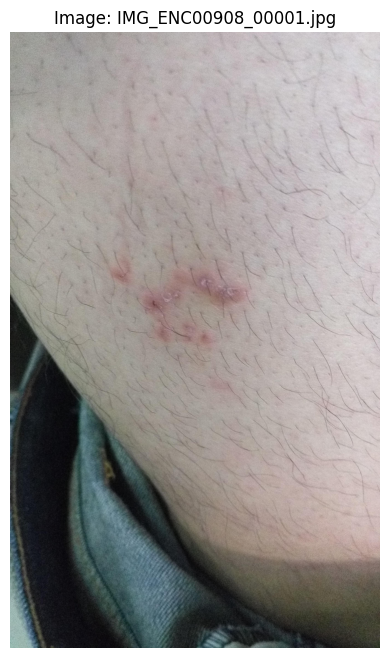


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

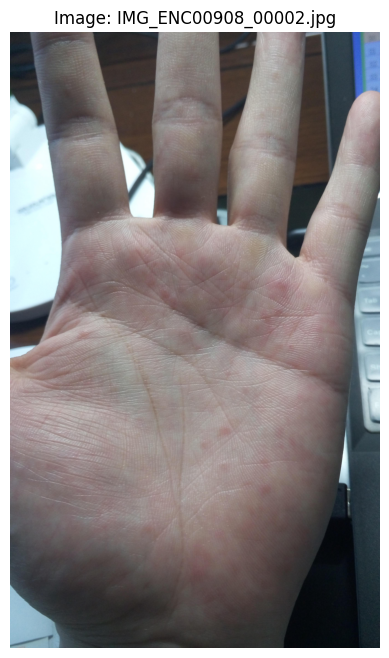


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

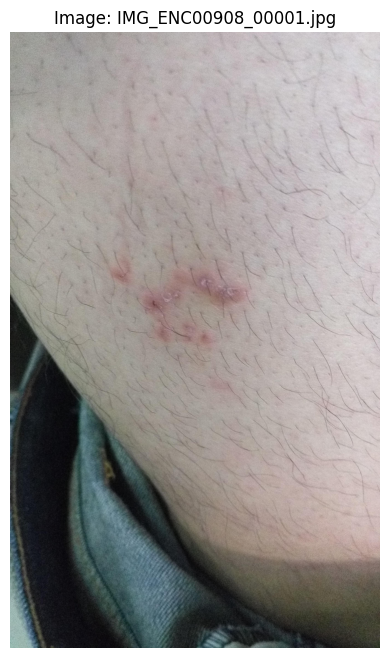


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

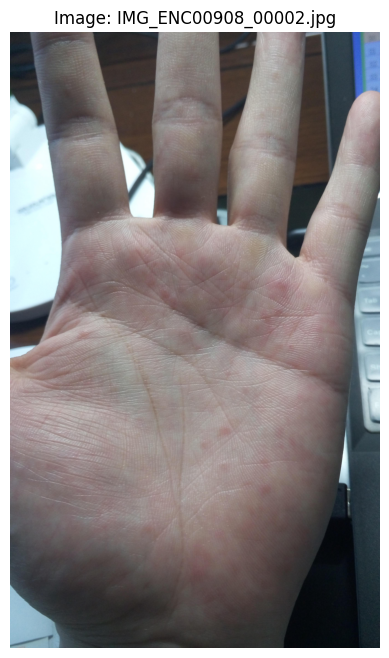


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

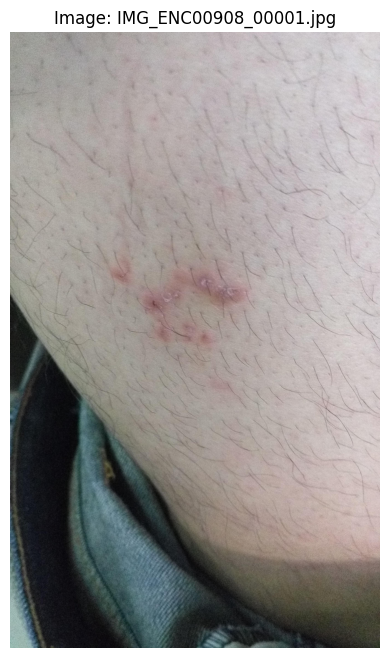


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

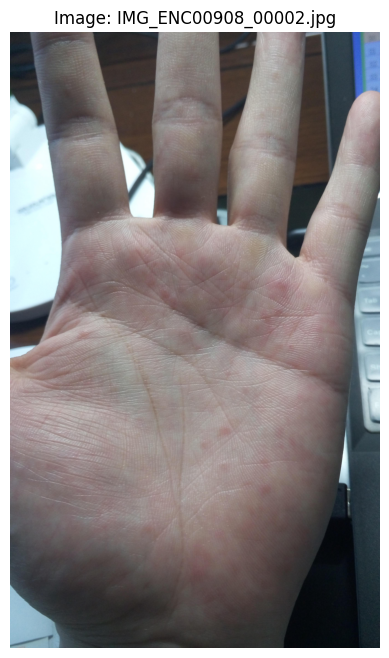


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

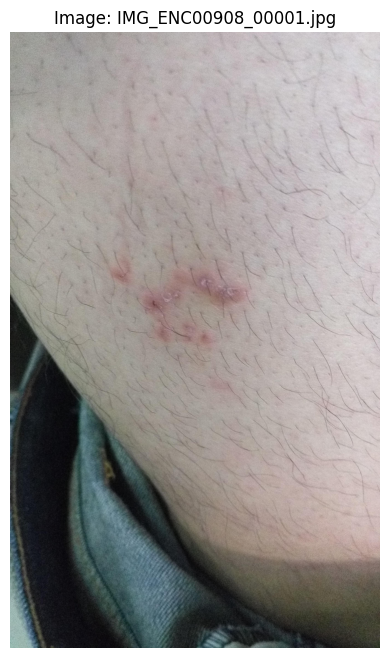


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

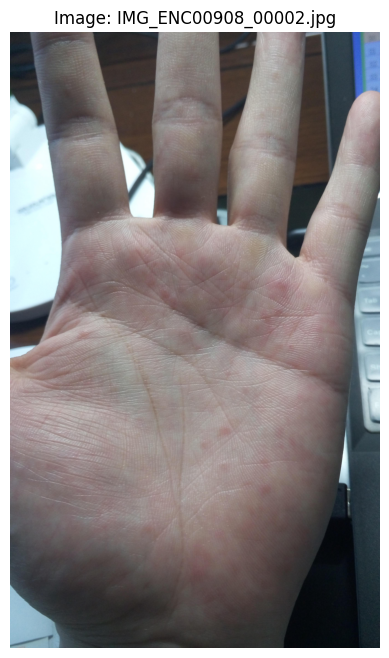


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

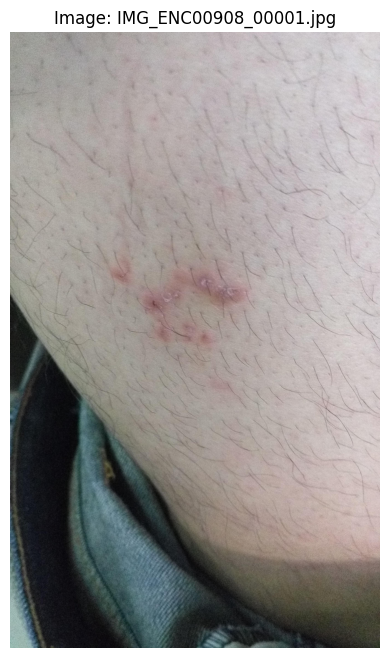


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

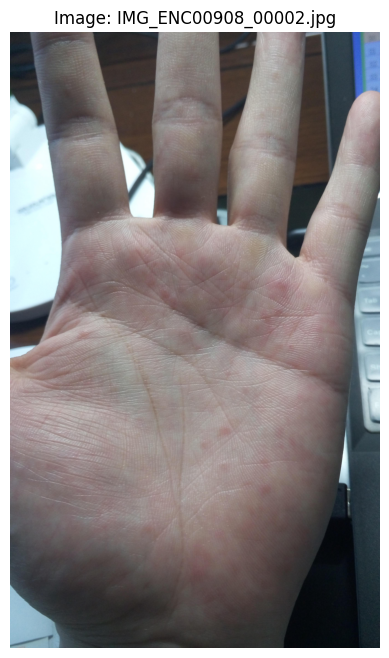


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

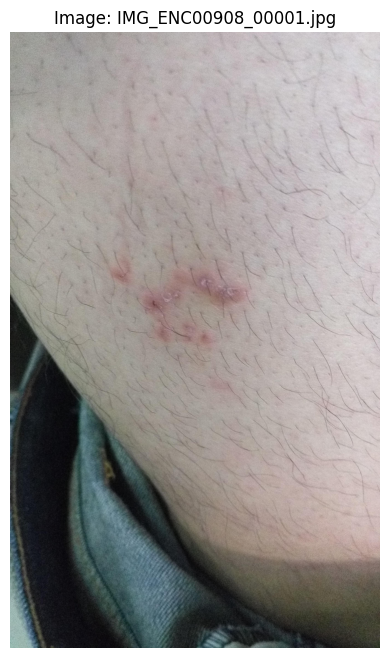


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

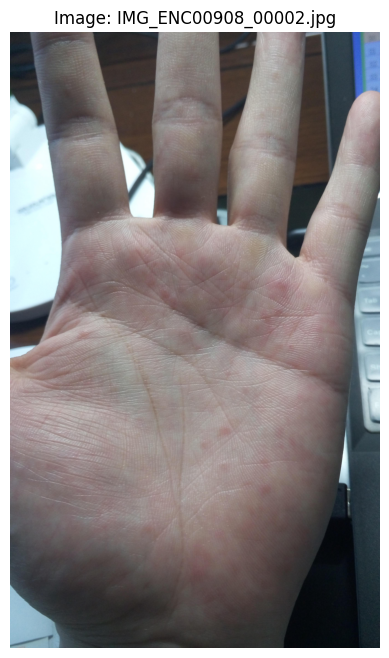


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

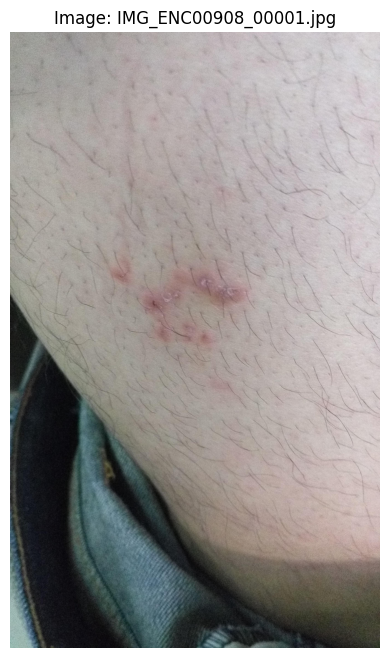


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

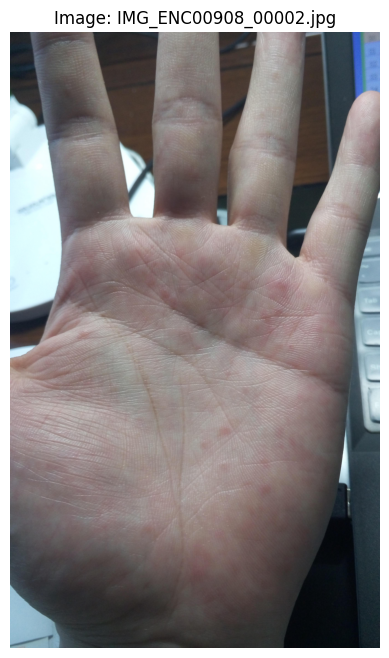


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

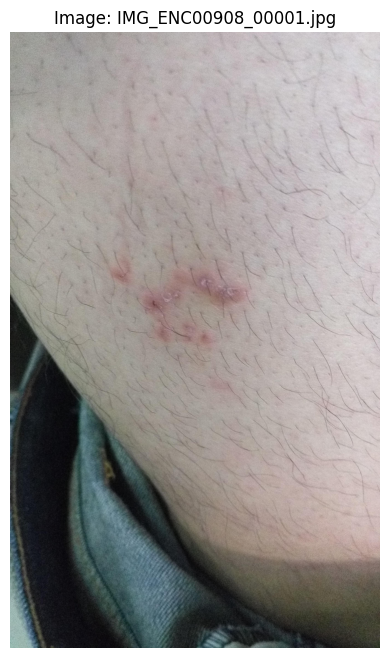


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

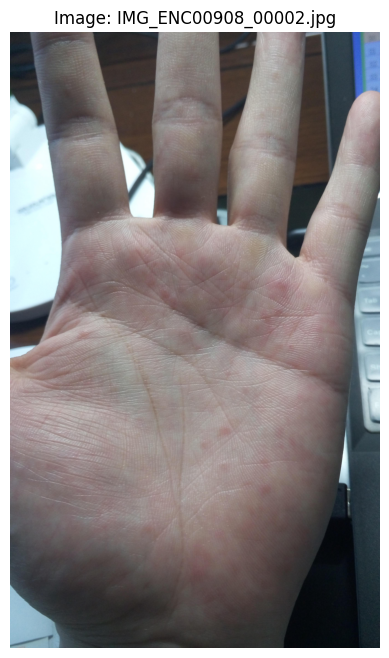


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

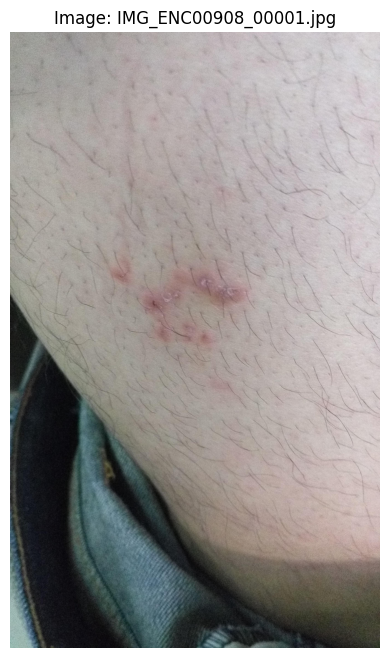


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

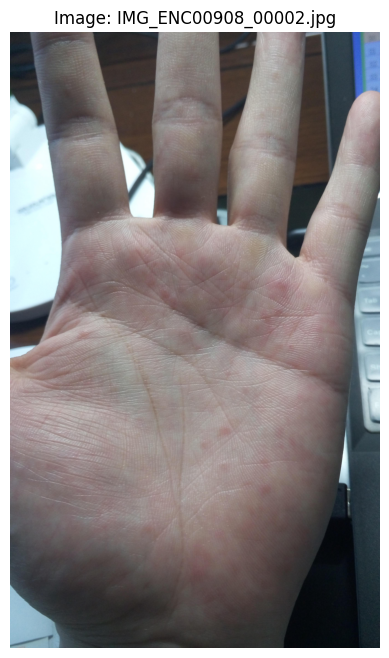


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

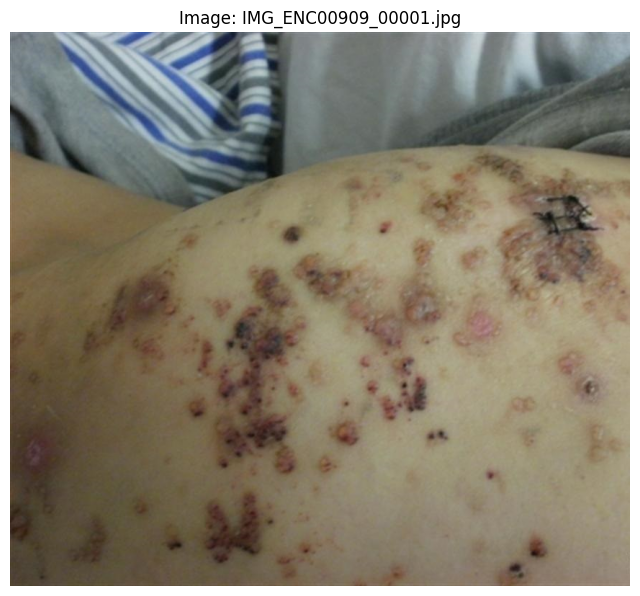


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

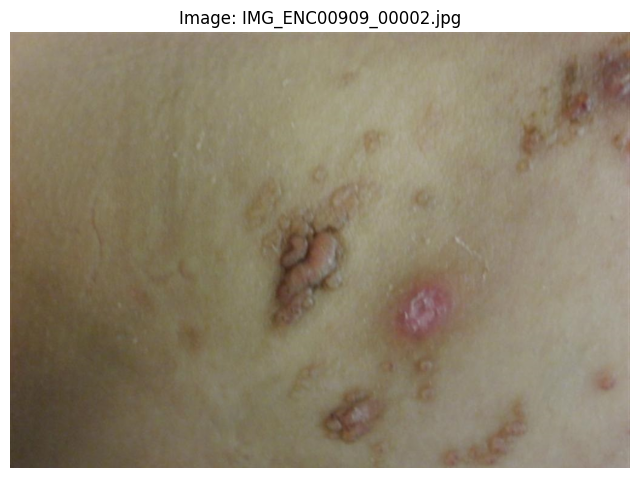


SYSTEM MESSAGE FOR INFERENCE:
--------------------------------------------------------------------------------
You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            
--------------------------------------------------------------------

In [16]:
visualize_test_examples(num_examples=20, show_images=True, batch_idx=0)

In [17]:
class MedicalImageInference:
    def __init__(self, model_path, token=None, adapter_path=None, device="cuda" if torch.cuda.is_available() else "cpu"):
        """
        Initialize the inference class for medical image analysis.
        Parameters:
        - model_path: Path to the model (base model or merged model)
        - token: HF token for downloading models
        - adapter_path: Path to adapter weights (only used if not using merged model)
        - device: Computing device (cuda or cpu)
        """
        self.device = device
        print(f"Loading processor from {model_path}...")
        self.processor = AutoProcessor.from_pretrained(model_path, token=token)

        base_kwargs = dict(
            torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
            device_map="auto" if torch.cuda.is_available() else None,
            low_cpu_mem_usage=True,
            token=token
        )

        print(f"Loading model from {model_path}...")
        if IS_LLAMA and adapter_path:
            self.model = MllamaForConditionalGeneration.from_pretrained(
                model_path,
                low_cpu_mem_usage=True,
                torch_dtype=torch.bfloat16,
                device_map="auto",
                token=token
            )
            print(f"Loading adapter from {adapter_path}...")
            from peft import PeftModel
            self.model = PeftModel.from_pretrained(self.model, adapter_path)
        elif IS_QWEN and adapter_path:

            base_kwargs["attn_implementation"] = "flash_attention_2" if torch.cuda.is_available() else "eager"
            if "Qwen2.5-VL" in model_path:
                self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
                    model_path,
                    **base_kwargs
                )
            else:
                self.model = Qwen2VLForConditionalGeneration.from_pretrained(
                    model_path,
                    **base_kwargs
                )
            print(f"Loading adapter from {adapter_path}...")
            from peft import PeftModel
            self.model = PeftModel.from_pretrained(self.model, adapter_path)
        else:

            if IS_LLAMA:
                self.model = MllamaForConditionalGeneration.from_pretrained(
                    model_path,
                    low_cpu_mem_usage=True,
                    torch_dtype=torch.bfloat16,
                    device_map="auto",
                    token=token
                )
            elif IS_QWEN:
                base_kwargs["attn_implementation"] = "flash_attention_2" if torch.cuda.is_available() else "eager"
                if "Qwen2.5-VL" in model_path:
                    self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
                        model_path,
                        **base_kwargs
                    )
                else:
                    self.model = Qwen2VLForConditionalGeneration.from_pretrained(
                        model_path,
                        **base_kwargs
                    )
            else:
                non_llama_kwargs = base_kwargs.copy()
                non_llama_kwargs["attn_implementation"] = "eager"
                self.model = AutoModelForImageTextToText.from_pretrained(
                    model_path,
                    **non_llama_kwargs
                )
        self.model.eval()
        self.IS_QWEN = IS_QWEN
        print("Model loaded successfully")

    def predict(self, query_text, image_path, max_new_tokens=100):
        try:

            image = Image.open(image_path).convert("RGB")

            system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

            IMPORTANT: 
            - Respond ONLY with the exact text of the option(s) that apply
            - Do not provide any explanations
            - Do not include the numbers that appear before options (like '1.' or '2')
            - Do not write "Options:" or similar prefixes
            - Do not write "Answer:" or similar prefixes
            - Multiple answers should be separated by commas
            - If unsure, respond with "Not mentioned"
            - The 'Background Clinical Information' section contains context to help you answer the main question
            - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
            """

            messages = [
                {
                    "role": "system",
                    "content": [{"type": "text", "text": system_message}],
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": query_text},
                        {"type": "image", "image": image},
                    ],
                }
            ]

            if self.IS_QWEN:
                text = self.processor.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=True
                )
                image_inputs, video_inputs = process_vision_info(messages)
                inputs = self.processor(
                    text=[text],
                    images=image_inputs,
                    videos=video_inputs,
                    padding=True,
                    return_tensors="pt",
                )
            else:
                inputs = self.processor(
                    text=self.processor.apply_chat_template(messages, tokenize=False),
                    images=image,
                    return_tensors="pt"
                )
            inputs = inputs.to(self.device)
                
            with torch.no_grad():
                generation_params = {
                    "max_new_tokens": max_new_tokens,
                    "do_sample": True,
                    "temperature": 0.9,
                    "top_p": 0.95,
                    "top_k": 64
                }

                if not (self.IS_QWEN or IS_LLAMA):
                    generation_params["disable_compile"] = True

                generated_ids = self.model.generate(
                    **inputs,
                    **generation_params
                )

            input_length = inputs.input_ids.shape[1]
            generated_ids_trimmed = [
                out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            prediction = self.processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0]

            prediction = prediction.strip()

            if prediction.startswith("assistant\n\n"):
                prediction = prediction[len("assistant\n\n"):]

            if prediction.startswith("assistant\n"):
                prediction = prediction[len("assistant\n"):]

            if prediction.startswith("system\n"):
                prediction = prediction[len("system\n"):]

            if prediction.startswith("model\n"):
                prediction = prediction[len("model\n"):]

            prediction = re.sub(r'^\*+\s*', '', prediction)
            prediction = re.sub(r'\n\*+\s*', ' ', prediction)
            prediction = re.sub(r'\*\s*', '', prediction)

            if prediction.startswith("Note:") or prediction.startswith("Disclaimer:") or prediction.startswith("*Note:"):
                if "\n" in prediction:
                    prediction = prediction.split("\n", 1)[1].strip()

            if "Answer:" in prediction:
                parts = prediction.split("Answer:")
                if len(parts) > 1:
                    prediction = parts[1].strip()

            if prediction.endswith("."):
                prediction = prediction[:-1]

            if prediction.startswith("<start_of_turn>model") or prediction.startswith("<start_of_turn>assistant"):
                prediction = prediction.split("\n", 1)[1] if "\n" in prediction else ""
            if prediction.endswith("<end_of_turn>"):
                prediction = prediction[:-len("<end_of_turn>")]

            return prediction.strip()

        except Exception as e:
            print(f"Error during prediction for {image_path}: {e}")
            traceback.print_exc()
            return "Not mentioned"
    
    def batch_predict(self, processed_data_dir=None, output_file=None, max_samples=None):
        """
        Run inference on a batch of preprocessed data
        """
        if processed_data_dir is None:
            processed_data_dir = PROCESSED_VAL_DATA_DIR

        if output_file is None:
            output_file = os.path.join(OUTPUT_DIR, "predictions.csv")

        results = []
        sample_count = 0

        # Determine the batch file prefix based on the directory
        if "test" in processed_data_dir.lower():
            batch_prefix = "test_batch_"
        else:
            batch_prefix = "val_batch_"

        batch_files = sorted([f for f in os.listdir(processed_data_dir) 
                              if f.startswith(batch_prefix) and f.endswith(".pkl")])

        if not batch_files:
            print(f"Warning: No batch files found in {processed_data_dir} with prefix {batch_prefix}")
            return pd.DataFrame()

        for batch_file in tqdm(batch_files, desc="Processing batches"):
            with open(os.path.join(processed_data_dir, batch_file), 'rb') as f:
                batch_data = pickle.load(f)

            for sample in tqdm(batch_data, desc=f"Predicting {batch_file}", leave=False):
                prediction = self.predict(sample["query_text"], sample["image_path"])

                results.append({
                    "encounter_id": sample.get("encounter_id", sample.get("id", "")),
                    "base_qid": sample.get("base_qid", sample.get("qid", "")),
                    "image_id": os.path.basename(sample["image_path"]),
                    "prediction": prediction
                })

                sample_count += 1
                if max_samples and sample_count >= max_samples:
                    break

            if max_samples and sample_count >= max_samples:
                break

        print(f"Processed {sample_count} samples for prediction")

        if not results:
            print("Warning: No prediction results generated")
            return pd.DataFrame()

        results_df = pd.DataFrame(results)
        results_df.to_csv(output_file, index=False)

        return results_df

    def aggregate_predictions(self, predictions_df, validation_df=None, test_df=None):
        """
        Aggregate predictions for each encounter and question ID.

        Parameters:
        - predictions_df: DataFrame with prediction results
        - validation_df: Optional DataFrame containing validation data with options_en
        - test_df: Optional DataFrame containing test data with options_en
        """
        max_answers = {
            'CQID010': 1,
            'CQID011': 6,
            'CQID012': 6,
            'CQID015': 1,
            'CQID020': 9,
            'CQID025': 1,
            'CQID034': 1,
            'CQID035': 1,
            'CQID036': 1
        }

        default_max_answers = 1

        grouped = predictions_df.groupby(['encounter_id', 'base_qid'])

        aggregated_results = []

        for (encounter_id, base_qid), group in tqdm(grouped, desc="Aggregating predictions"):
            predictions = group['prediction'].tolist()
            image_ids = group['image_id'].tolist()

            cleaned_predictions = []
            for pred in predictions:
                if isinstance(pred, str):
                    pred = pred.replace(" (please specify)", "")

                    if pred.startswith('[') and pred.endswith(']'):
                        try:
                            pred_list = safe_convert_options(pred)
                            if isinstance(pred_list, list):
                                pred_list = [p.replace(" (please specify)", "") if isinstance(p, str) else p for p in pred_list]
                                cleaned_predictions.extend(pred_list)
                                continue
                        except:
                            pass

                    if ',' in pred:
                        items = [p.strip().replace(" (please specify)", "") for p in pred.split(',')]
                        cleaned_predictions.extend(items)
                    else:
                        cleaned_predictions.append(pred.strip())
                else:
                    cleaned_predictions.append(str(pred).strip())

            all_cleaned_predictions = cleaned_predictions.copy()

            cleaned_predictions = [p.lower() if isinstance(p, str) else str(p).lower() for p in cleaned_predictions]
            prediction_counts = Counter(cleaned_predictions)

            question_type = base_qid.split('-')[0] if '-' in base_qid else base_qid

            allowed_max = max_answers.get(question_type, default_max_answers)

            sorted_predictions = sorted(prediction_counts.items(), 
                                       key=lambda x: x[1], 
                                       reverse=True)

            all_sorted_predictions = sorted_predictions.copy()

            top_predictions = [p[0] for p in sorted_predictions[:allowed_max]]

            if len(sorted_predictions) > allowed_max:
                cutoff_count = sorted_predictions[allowed_max-1][1]
                tied_predictions = [p[0] for p in sorted_predictions if p[1] == cutoff_count]

                if len(tied_predictions) > 1 and len(top_predictions) > allowed_max - len(tied_predictions):
                    top_predictions = [p for p in top_predictions if p not in tied_predictions]

                    random.seed(42)
                    slots_remaining = allowed_max - len(top_predictions)
                    selected_tied = random.sample(tied_predictions, slots_remaining)

                    top_predictions.extend(selected_tied)

            if len(top_predictions) > 1 and "not mentioned" in top_predictions:
                top_predictions.remove("not mentioned")

            combined_prediction = ", ".join(top_predictions)

            options_en = None

            # Try to get options from validation_df first
            if validation_df is not None:
                matching_rows = validation_df[(validation_df['encounter_id'] == encounter_id) & 
                                             (validation_df['base_qid'] == base_qid)]
                if not matching_rows.empty:
                    options_en = matching_rows.iloc[0].get('options_en')

            # If not found and test_df is provided, try there
            if options_en is None and test_df is not None:
                matching_rows = test_df[(test_df['encounter_id'] == encounter_id) & 
                                        (test_df['base_qid'] == base_qid)]
                if not matching_rows.empty:
                    options_en = matching_rows.iloc[0].get('options_en')

            result_dict = {
                "encounter_id": encounter_id,
                "base_qid": base_qid,
                "image_ids": image_ids,
                "unique_predictions": top_predictions,
                "combined_prediction": combined_prediction,
                "all_raw_predictions": all_cleaned_predictions,
                "all_sorted_predictions": all_sorted_predictions
            }

            if options_en is not None:
                result_dict["options_en"] = options_en

            aggregated_results.append(result_dict)

        aggregated_df = pd.DataFrame(aggregated_results)

        return aggregated_df

In [18]:
def run_test_inference():
    """
    Run inference on the test dataset.
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_type = "finetuned" if args.use_finetuning else "base"
    inference_id = f"{MODEL_NAME}_{model_type}_{timestamp}"
    
    inference = MedicalImageInference(
        model_path=args.model_path,
        token=HF_TOKEN,
        adapter_path=args.adapter_path
    )
    
    predictions_file = os.path.join(OUTPUT_DIR, 
                              f"test_predictions_{inference_id}_{timestamp}{'_test' if args.test else ''}.csv")
    
    print(f"Running inference on test data (max_samples={args.max_samples if args.max_samples else 'all'})...")
    
    predictions_df = inference.batch_predict(
        processed_data_dir=PROCESSED_TEST_DATA_DIR,
        output_file=predictions_file,
        max_samples=args.max_samples
    )
    
    return predictions_df, inference, inference_id, timestamp, predictions_file

In [19]:
def format_predictions_for_official_eval_with_display(aggregated_df, output_file):
    """
    Format predictions as expected by the official evaluation script,
    mapping text answers to indices and distributing multiple answers
    across question variants when appropriate.
    Also displays the text values alongside their indices for verification.
    """
    QIDS = [
        "CQID010-001",
        "CQID011-001", "CQID011-002", "CQID011-003", "CQID011-004", "CQID011-005", "CQID011-006",
        "CQID012-001", "CQID012-002", "CQID012-003", "CQID012-004", "CQID012-005", "CQID012-006",
        "CQID015-001",
        "CQID020-001", "CQID020-002", "CQID020-003", "CQID020-004", "CQID020-005", 
        "CQID020-006", "CQID020-007", "CQID020-008", "CQID020-009",
        "CQID025-001",
        "CQID034-001",
        "CQID035-001",
        "CQID036-001",
    ]
    
    qid_variants = {}
    for qid in QIDS:
        base_qid, variant = qid.split('-')
        if base_qid not in qid_variants:
            qid_variants[base_qid] = []
        qid_variants[base_qid].append(qid)
    
    required_base_qids = set(qid.split('-')[0] for qid in QIDS)
    
    formatted_predictions = []
    display_info = []
    
    for encounter_id, group in aggregated_df.groupby('encounter_id'):
        encounter_base_qids = set(group['base_qid'].unique())
        
        if not required_base_qids.issubset(encounter_base_qids):
            print(f"Skipping encounter {encounter_id} - missing required questions")
            continue
        
        pred_entry = {'encounter_id': encounter_id}
        encounter_display = {'encounter_id': encounter_id, 'questions': []}
        
        for _, row in group.iterrows():
            base_qid = row['base_qid']
            
            if base_qid not in qid_variants:
                continue
            
            options = safe_convert_options(row['options_en'])
            
            not_mentioned_index = None
            for i, opt in enumerate(options):
                if opt == "Not mentioned":
                    not_mentioned_index = i
                    break
            
            if not_mentioned_index is None:
                not_mentioned_index = len(options) - 1
            
            if isinstance(row['unique_predictions'], list):
                predictions = row['unique_predictions']
            else:
                try:
                    predictions = eval(row['unique_predictions'])
                except:
                    predictions = [row['unique_predictions']]
            
            prediction_indices = []
            prediction_texts = []
            
            for pred in predictions:
                pred_text = str(pred).strip()
                prediction_texts.append(pred_text)
                        
                found = False
                for i, option in enumerate(options):
                    clean_option = option.replace(" (please specify)", "").lower()

                    if pred_text.lower() == clean_option:
                        prediction_indices.append(i)
                        found = True
                        break
                
                if not found:
                    prediction_indices.append(100)
            
            unique_indices = []
            unique_texts = []
            for idx, text in zip(prediction_indices, prediction_texts):
                if idx not in unique_indices:
                    unique_indices.append(idx)
                    unique_texts.append(text)
            
            if len(unique_indices) > 1 and 100 in unique_indices:
                idx_to_remove = unique_indices.index(100)
                unique_indices.remove(100)
                unique_texts.pop(idx_to_remove)
            
            available_variants = qid_variants[base_qid]
            
            question_display = {
                'base_qid': base_qid,
                'predicted_texts': unique_texts,
                'predicted_indices': unique_indices,
                'options': options,
                'not_mentioned_index': not_mentioned_index,
                'variant_assignments': {}
            }
            
            if len(available_variants) == 1:
                if unique_indices:
                    pred_entry[available_variants[0]] = unique_indices[0]
                    question_display['variant_assignments'][available_variants[0]] = {
                        'index': unique_indices[0],
                        'text': unique_texts[0] if unique_texts else "None"
                    }
                else:
                    pred_entry[available_variants[0]] = not_mentioned_index
                    question_display['variant_assignments'][available_variants[0]] = {
                        'index': not_mentioned_index,
                        'text': "Not mentioned"
                    }
            
            else:
                for i, idx in enumerate(unique_indices):
                    if i < len(available_variants):
                        pred_entry[available_variants[i]] = idx
                        question_display['variant_assignments'][available_variants[i]] = {
                            'index': idx,
                            'text': unique_texts[i] if i < len(unique_texts) else "None"
                        }
                
                for i in range(len(unique_indices), len(available_variants)):
                    pred_entry[available_variants[i]] = not_mentioned_index
                    question_display['variant_assignments'][available_variants[i]] = {
                        'index': not_mentioned_index,
                        'text': "Not mentioned"
                    }
            
            encounter_display['questions'].append(question_display)
        
        formatted_predictions.append(pred_entry)
        display_info.append(encounter_display)
    
    if not formatted_predictions:
        print("Warning: No complete encounters found in the data!")
    
    with open(output_file, 'w') as f:
        json.dump(formatted_predictions, f, indent=2)
    
    for encounter in display_info:
        print(f"\nEncounter: {encounter['encounter_id']}")
        for question in encounter['questions']:
            print(f"  Question: {question['base_qid']}")
            print(f"  Predicted texts: {question['predicted_texts']}")
            print(f"  Predicted indices: {question['predicted_indices']}")
            print(f"  'Not mentioned' index: {question['not_mentioned_index']}")
            print("  Variant assignments:")
            for variant, assignment in question['variant_assignments'].items():
                print(f"    {variant}: index={assignment['index']} ({assignment['text']})")
            print(f"  Available options: {question['options']}")
            print()
    
    print(f"Formatted predictions saved to {output_file} ({len(formatted_predictions)} complete encounters)")
    return formatted_predictions

In [20]:
test_predictions_df, inference, TEST_INFERENCE_MODEL_ID, TEST_INFERENCE_TIMESTAMP, test_predictions_file = run_test_inference()
print("Aggregating test predictions...")

Loading processor from /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/merged/Qwen2.5-VL-7B-Instruct_checkpoint-738_20250501_1805...
Loading model from /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/merged/Qwen2.5-VL-7B-Instruct_checkpoint-738_20250501_1805...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded successfully
Running inference on test data (max_samples=all)...


Processing batches:   0%|          | 0/29 [00:00<?, ?it/s]

Predicting test_batch_0.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_1.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_10.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_11.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_12.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_13.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_14.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_15.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_16.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_17.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_18.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_19.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_2.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_20.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_21.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_22.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_23.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_24.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_25.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_26.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_27.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_28.pkl:   0%|          | 0/26 [00:00<?, ?it/s]

Predicting test_batch_3.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_4.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_5.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_6.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_7.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_8.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Predicting test_batch_9.pkl:   0%|          | 0/100 [00:00<?, ?it/s]

Processed 2826 samples for prediction
Aggregating test predictions...


In [21]:
test_predictions_df.head()

encounter_id base_qid                image_id  \
0     ENC00908  CQID010  IMG_ENC00908_00001.jpg   
1     ENC00908  CQID010  IMG_ENC00908_00002.jpg   
2     ENC00908  CQID011  IMG_ENC00908_00001.jpg   
3     ENC00908  CQID011  IMG_ENC00908_00002.jpg   
4     ENC00908  CQID012  IMG_ENC00908_00001.jpg   

                                          prediction  
0  limited area, single spot, widespread, single ...  
1  limited area, single spot, widespread, single ...  
2  lower extremities, back, other, chest/abdomen,...  
3  upper extremities, lower extremities, other, c...  
4  size of palm, size of thumb nail, larger area,...

In [22]:
# aggregated_df = inference.aggregate_predictions(test_predictions_df)
aggregated_df = inference.aggregate_predictions(test_predictions_df, test_df=test_df)

Aggregating predictions:   0%|          | 0/900 [00:00<?, ?it/s]

In [23]:
aggregated_file = os.path.join(OUTPUT_DIR, 
                             f"aggregated_test_predictions_{TEST_INFERENCE_MODEL_ID}_{TEST_INFERENCE_TIMESTAMP}{'_test' if args.test else ''}.csv")
aggregated_df.to_csv(aggregated_file, index=False)

In [24]:
test_predictions_json = os.path.join(OUTPUT_DIR, 
                                  f"test_data_cvqa_sys_{TEST_INFERENCE_MODEL_ID}_{TEST_INFERENCE_TIMESTAMP}{'_test' if args.test else ''}.json")
format_predictions_for_official_eval_with_display(aggregated_df, test_predictions_json)
print(f"Formatted test predictions saved to {test_predictions_json}")


Encounter: ENC00908
  Question: CQID010
  Predicted texts: ['single spot']
  Predicted indices: [0]
  'Not mentioned' index: 3
  Variant assignments:
    CQID010-001: index=0 (single spot)
  Available options: ['single spot', 'limited area', 'widespread', 'Not mentioned']

  Question: CQID011
  Predicted texts: ['lower extremities', 'other', 'back', 'chest/abdomen', 'upper extremities']
  Predicted indices: [3, 6, 5, 4, 2]
  'Not mentioned' index: 7
  Variant assignments:
    CQID011-001: index=3 (lower extremities)
    CQID011-002: index=6 (other)
    CQID011-003: index=5 (back)
    CQID011-004: index=4 (chest/abdomen)
    CQID011-005: index=2 (upper extremities)
    CQID011-006: index=7 (Not mentioned)
  Available options: ['head', 'neck', 'upper extremities', 'lower extremities', 'chest/abdomen', 'back', 'other', 'Not mentioned']

  Question: CQID012
  Predicted texts: ['size of palm', 'size of thumb nail', 'larger area']
  Predicted indices: [1, 0, 2]
  'Not mentioned' index: 3
  

In [25]:
SUBMISSION_TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
submission_dir = os.path.join(OUTPUT_DIR, f"test_submission_{TEST_INFERENCE_MODEL_ID}_{SUBMISSION_TIMESTAMP}")
os.makedirs(submission_dir, exist_ok=True)

dest_json = os.path.join(submission_dir, "data_cvqa_sys.json")
shutil.copy2(test_predictions_json, dest_json)

submission_masks_dir = os.path.join(submission_dir, "masks_preds")
os.makedirs(submission_masks_dir, exist_ok=True)

zip_path = os.path.join(OUTPUT_DIR, f"test_submission_{TEST_INFERENCE_MODEL_ID}_{SUBMISSION_TIMESTAMP}.zip")
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(dest_json, arcname="data_cvqa_sys.json")
    zipf.write(submission_masks_dir, arcname="masks_preds")

print(f"Test submission package created at: {zip_path}")
print(f"Files included:")
print(f" - data_cvqa_sys.json (copied from {test_predictions_json})")
print(f" - masks_preds/ (empty directory)")

Test submission package created at: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/test_submission_Qwen2.5-VL-7B-Instruct_finetuned_20250501_180704_20250501_205556.zip
Files included:
 - data_cvqa_sys.json (copied from /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/test_data_cvqa_sys_Qwen2.5-VL-7B-Instruct_finetuned_20250501_180704_20250501_180704.json)
 - masks_preds/ (empty directory)


In [26]:
INFERENCE_MODEL_ID = TEST_INFERENCE_MODEL_ID

In [27]:
INFERENCE_TIMESTAMP = TEST_INFERENCE_TIMESTAMP

In [28]:
TEST_SUFFIX = '_test' if args.test else ''

In [ ]:
def run_inference():
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_type = "finetuned" if args.use_finetuning else "base"
    inference_id = f"{MODEL_NAME}_{model_type}_{timestamp}"
    
    inference = MedicalImageInference(
        model_path=args.model_path,
        token=HF_TOKEN,
        adapter_path=args.adapter_path
    )
    
    predictions_file = os.path.join(OUTPUT_DIR, 
                              f"val_predictions_{inference_id}_{timestamp}{'_test' if args.test else ''}.csv")
    
    print(f"Running inference (max_samples={args.max_samples if args.max_samples else 'all'})...")
    predictions_df = inference.batch_predict(PROCESSED_VAL_DATA_DIR, predictions_file, max_samples=args.max_samples)
    return predictions_df, inference, inference_id, timestamp, predictions_file

In [ ]:
predictions_df, inference, INFERENCE_MODEL_ID, INFERENCE_TIMESTAMP, predictions_file = run_inference()

In [ ]:
print("Aggregating predictions...")

val_dataset_path = os.path.join(OUTPUT_DIR, "val_dataset.csv")
val_dataset = pd.read_csv(val_dataset_path)

aggregated_df = inference.aggregate_predictions(predictions_df, validation_df=val_dataset)

aggregated_file = os.path.join(OUTPUT_DIR, 
                             f"aggregated_predictions_{INFERENCE_MODEL_ID}_{INFERENCE_TIMESTAMP}{'_test' if args.test else ''}.csv")
aggregated_df.to_csv(aggregated_file, index=False)

print(f"Inference complete. Results saved to {predictions_file} and {aggregated_file}")

In [ ]:
print("\nSample of raw predictions:")
predictions_df.head(3)

In [ ]:
print("\nSample of aggregated predictions:")
aggregated_df.head(3)

In [ ]:
TEST_SUFFIX = '_test' if args.test else ''

prediction_pattern = os.path.join(OUTPUT_DIR, f"val_predictions_*{TEST_SUFFIX}.csv")
prediction_files = sorted(glob.glob(prediction_pattern), key=os.path.getmtime, reverse=True)
if not prediction_files:
    raise FileNotFoundError(f"No prediction files found matching pattern {prediction_pattern}")
LATEST_PREDICTION_FILE = prediction_files[0]
print(f"Loading latest prediction file: {LATEST_PREDICTION_FILE}")
predictions = pd.read_csv(LATEST_PREDICTION_FILE)

aggregated_pattern = os.path.join(OUTPUT_DIR, f"aggregated_predictions_*{TEST_SUFFIX}.csv")
aggregated_files = sorted(glob.glob(aggregated_pattern), key=os.path.getmtime, reverse=True)
if not aggregated_files:
    raise FileNotFoundError(f"No aggregated files found matching pattern {aggregated_pattern}")
LATEST_AGGREGATED_FILE = aggregated_files[0]
print(f"Loading latest aggregated file: {LATEST_AGGREGATED_FILE}")
aggregated = pd.read_csv(LATEST_AGGREGATED_FILE)

In [ ]:
multi_answer_preds = predictions[predictions['prediction'].str.contains(',', na=False)]

print("Sample of predictions with multiple answers:")
multi_answer_preds[["encounter_id", "base_qid", "image_id", "prediction"]].head(20)

In [ ]:
print(f"\nTotal multi-answer predictions: {len(multi_answer_preds)}")

print("\nMulti-answer predictions by question type:")
multi_answer_preds['base_qid'].value_counts()

In [ ]:
print("\nSample of aggregated predictions:")
aggregated.head(5)

In [ ]:
agg_result = aggregated[
    (aggregated['encounter_id'] == 'ENC00852') & 
    (aggregated['base_qid'] == 'CQID034')
]
agg_result

In [ ]:
answer_counts = predictions["prediction"].value_counts().head(10)
print("\nMost common predictions:")
print(answer_counts)

In [ ]:
predictions_json = os.path.join(OUTPUT_DIR, 
                              f"data_cvqa_sys_{INFERENCE_MODEL_ID}_{INFERENCE_TIMESTAMP}{TEST_SUFFIX}.json")
format_predictions_for_official_eval_with_display(aggregated, predictions_json)
print(f"Formatted predictions saved to {predictions_json}")

In [ ]:
specific_question = val_dataset[(val_dataset['encounter_id'] == 'ENC00853') & 
                               (val_dataset['base_qid'] == 'CQID012')]

print("Question Information:")
print(f"Question text: {specific_question['question_text'].values[0]}")
print(f"Question type: {specific_question['question_type_en'].values[0]}")
print(f"Question category: {specific_question['question_category_en'].values[0]}")
print(f"Options: {specific_question['options_en'].values[0]}")
print(f"Multi-label: {specific_question['is_multi_label'].values[0]}")
print("\nClinical Context:")
print(f"Query title: {specific_question['query_title_en'].values[0]}")
print(f"Query content: {specific_question['query_content_en'].values[0]}")
print("\nImage information:")
print(f"Image ID: {specific_question['image_id'].values[0]}")
print(f"Image path: {specific_question['image_path'].values[0]}")

In [29]:
# json_pattern = os.path.join(OUTPUT_DIR, f"data_cvqa_sys_{INFERENCE_MODEL_ID}_{INFERENCE_TIMESTAMP}{TEST_SUFFIX}.json")
# json_files = sorted(glob.glob(json_pattern), key=os.path.getmtime, reverse=True)
# if not json_files:
#     raise FileNotFoundError(f"No JSON prediction files found matching pattern {json_pattern}")
    
# predictions_file_path = json_files[0]
# print(f"Using most recent prediction JSON: {predictions_file_path}")

json_pattern = os.path.join(OUTPUT_DIR, f"data_cvqa_sys_{INFERENCE_MODEL_ID}_{INFERENCE_TIMESTAMP}{TEST_SUFFIX}.json")
json_files = sorted(glob.glob(json_pattern), key=os.path.getmtime, reverse=True)

# If regular pattern fails, try with test_ prefix
if not json_files:
    test_json_pattern = os.path.join(OUTPUT_DIR, f"test_data_cvqa_sys_{TEST_INFERENCE_MODEL_ID}_{TEST_INFERENCE_TIMESTAMP}{TEST_SUFFIX}.json")
    json_files = sorted(glob.glob(test_json_pattern), key=os.path.getmtime, reverse=True)
    
    if not json_files:
        # Try a more flexible pattern as last resort
        fallback_pattern = os.path.join(OUTPUT_DIR, f"*data_cvqa_sys_*{TEST_SUFFIX}.json")
        json_files = sorted(glob.glob(fallback_pattern), key=os.path.getmtime, reverse=True)
        
        if not json_files:
            raise FileNotFoundError(f"No JSON prediction files found with any pattern")

predictions_file_path = json_files[0]
print(f"Using prediction JSON: {predictions_file_path}")

with open(predictions_file_path, 'r') as f:
    formatted_preds = json.load(f)
    
print("First 3 prediction entries:")
for i in range(min(3, len(formatted_preds))):
    print(f"\nPrediction {i+1}:")
    pprint(formatted_preds[i])

print("\nLooking for predictions with index 100 (not in options):")
found = False
for entry in formatted_preds:
    for key, value in entry.items():
        if key != 'encounter_id':
            if (isinstance(value, list) and 100 in value) or value == 100:
                print(f"\nFound prediction not in options:")
                print(f"Encounter: {entry['encounter_id']}")
                print(f"Question: {key}")
                print(f"Prediction indices: {value}")
                
                aggregated_file_path = os.path.join(OUTPUT_DIR, 
                                                  f"aggregated_predictions_{INFERENCE_MODEL_ID}_{INFERENCE_TIMESTAMP}{TEST_SUFFIX}.csv")
                
                if not os.path.exists(aggregated_file_path):
                    print(f"Warning: Could not find aggregated predictions file at {aggregated_file_path}")
                    agg_pattern = os.path.join(OUTPUT_DIR, f"aggregated_predictions_*{TEST_SUFFIX}.csv")
                    agg_files = sorted(glob.glob(agg_pattern), key=os.path.getmtime, reverse=True)
                    if agg_files:
                        aggregated_file_path = agg_files[0]
                        print(f"Using most recent aggregated file instead: {aggregated_file_path}")
                    else:
                        print("No aggregated prediction files found. Skipping detailed analysis.")
                        continue
                
                agg_df = pd.read_csv(aggregated_file_path)
                base_qid = key.split('-')[0]
                encounter = entry['encounter_id']
                match = agg_df[(agg_df['encounter_id'] == encounter) & (agg_df['base_qid'] == base_qid)]
                if not match.empty:
                    print(f"Original prediction text: {match['combined_prediction'].values[0]}")
                    print(f"Available options: {match['options_en'].values[0]}")
                found = True
                break
    if found:
        break

if not found:
    print("No predictions with index 100 found in the first few entries.")

question_counts = {}
for entry in formatted_preds:
    qid_count = len(entry) - 1
    if qid_count in question_counts:
        question_counts[qid_count] += 1
    else:
        question_counts[qid_count] = 1

print("\nNumber of questions per encounter:")
for count, num_entries in sorted(question_counts.items()):
    print(f"{count} questions: {num_entries} encounters")

Using prediction JSON: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/test_data_cvqa_sys_Qwen2.5-VL-7B-Instruct_finetuned_20250501_180704_20250501_180704.json
First 3 prediction entries:

Prediction 1:
{'CQID010-001': 0,
 'CQID011-001': 3,
 'CQID011-002': 6,
 'CQID011-003': 5,
 'CQID011-004': 4,
 'CQID011-005': 2,
 'CQID011-006': 7,
 'CQID012-001': 1,
 'CQID012-002': 0,
 'CQID012-003': 2,
 'CQID012-004': 3,
 'CQID012-005': 3,
 'CQID012-006': 3,
 'CQID015-001': 5,
 'CQID020-001': 4,
 'CQID020-002': 7,
 'CQID020-003': 6,
 'CQID020-004': 3,
 'CQID020-005': 0,
 'CQID020-006': 8,
 'CQID020-007': 9,
 'CQID020-008': 9,
 'CQID020-009': 9,
 'CQID025-001': 0,
 'CQID034-001': 10,
 'CQID035-001': 1,
 'CQID036-001': 1,
 'encounter_id': 'ENC00908'}

Prediction 2:
{'CQID010-001': 2,
 'CQID011-001': 3,
 'CQID011-002': 6,
 'CQID011-003': 4,
 'CQID011-004': 5,
 'CQID011-005': 2,
 'CQID011-006': 7,
 'CQID012-001': 1,
 'CQID012-002': 0,
 'CQID012-003': 2,
 'CQID012-004': 3,
 'CQID012-005': 3,
 'CQI

In [30]:
SUBMISSION_TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Try first with the regular pattern
json_pattern = os.path.join(OUTPUT_DIR, f"data_cvqa_sys_{INFERENCE_MODEL_ID}*{TEST_SUFFIX}.json")
json_files = sorted(glob.glob(json_pattern), key=os.path.getmtime, reverse=True)

# If regular pattern fails, try with test_ prefix
if not json_files:
    test_json_pattern = os.path.join(OUTPUT_DIR, f"test_data_cvqa_sys_{TEST_INFERENCE_MODEL_ID}*{TEST_SUFFIX}.json")
    json_files = sorted(glob.glob(test_json_pattern), key=os.path.getmtime, reverse=True)
    
    if not json_files:
        # Try a more flexible pattern as last resort
        fallback_pattern = os.path.join(OUTPUT_DIR, f"*data_cvqa_sys_*{TEST_SUFFIX}.json")
        json_files = sorted(glob.glob(fallback_pattern), key=os.path.getmtime, reverse=True)
        
        if not json_files:
            raise FileNotFoundError(f"No JSON prediction files found with any pattern")

most_recent_json = json_files[0]
print(f"Using most recent prediction JSON: {most_recent_json}")

# Create submission directory and prepare files
masks_preds_dir = os.path.join(OUTPUT_DIR, "masks_preds")
os.makedirs(masks_preds_dir, exist_ok=True)

# Use TEST_INFERENCE_MODEL_ID if it exists, otherwise use INFERENCE_MODEL_ID
model_id_for_submission = TEST_INFERENCE_MODEL_ID if 'TEST_INFERENCE_MODEL_ID' in globals() else INFERENCE_MODEL_ID
submission_dir = os.path.join(OUTPUT_DIR, f"submission_{model_id_for_submission}_{SUBMISSION_TIMESTAMP}")
os.makedirs(submission_dir, exist_ok=True)

dest_json = os.path.join(submission_dir, "data_cvqa_sys.json")
shutil.copy2(most_recent_json, dest_json)

submission_masks_dir = os.path.join(submission_dir, "masks_preds")
os.makedirs(submission_masks_dir, exist_ok=True)

zip_path = os.path.join(OUTPUT_DIR, f"mysubmission_{model_id_for_submission}_{SUBMISSION_TIMESTAMP}.zip")
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(dest_json, arcname="data_cvqa_sys.json")
    zipf.write(submission_masks_dir, arcname="masks_preds")

print(f"Submission package created at: {zip_path}")
print(f"Files included:")
print(f" - data_cvqa_sys.json (copied from {most_recent_json})")
print(f" - masks_preds/ (empty directory)")

Using most recent prediction JSON: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/test_data_cvqa_sys_Qwen2.5-VL-7B-Instruct_finetuned_20250501_180704_20250501_180704.json
Submission package created at: /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/mysubmission_Qwen2.5-VL-7B-Instruct_finetuned_20250501_180704_20250501_205557.zip
Files included:
 - data_cvqa_sys.json (copied from /storage/scratch1/2/kthakrar3/mediqa-magic-v2/outputs/test_data_cvqa_sys_Qwen2.5-VL-7B-Instruct_finetuned_20250501_180704_20250501_180704.json)
 - masks_preds/ (empty directory)


In [31]:
# SUBMISSION_TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# json_pattern = os.path.join(OUTPUT_DIR, f"data_cvqa_sys_{INFERENCE_MODEL_ID}*{TEST_SUFFIX}.json")
# json_files = sorted(glob.glob(json_pattern), key=os.path.getmtime, reverse=True)
# if not json_files:
#     raise FileNotFoundError(f"No JSON prediction files found matching pattern {json_pattern}")
# most_recent_json = json_files[0]
# print(f"Using most recent prediction JSON: {most_recent_json}")

# masks_preds_dir = os.path.join(OUTPUT_DIR, "masks_preds")
# os.makedirs(masks_preds_dir, exist_ok=True)

# submission_dir = os.path.join(OUTPUT_DIR, f"submission_{INFERENCE_MODEL_ID}_{SUBMISSION_TIMESTAMP}")
# os.makedirs(submission_dir, exist_ok=True)

# dest_json = os.path.join(submission_dir, "data_cvqa_sys.json")
# shutil.copy2(most_recent_json, dest_json)

# submission_masks_dir = os.path.join(submission_dir, "masks_preds")
# os.makedirs(submission_masks_dir, exist_ok=True)

# zip_path = os.path.join(OUTPUT_DIR, f"mysubmission_{INFERENCE_MODEL_ID}_{SUBMISSION_TIMESTAMP}.zip")
# with zipfile.ZipFile(zip_path, 'w') as zipf:
#     zipf.write(dest_json, arcname="data_cvqa_sys.json")
    
#     zipf.write(submission_masks_dir, arcname="masks_preds")

# print(f"Submission package created at: {zip_path}")
# print(f"Files included:")
# print(f" - data_cvqa_sys.json (copied from {most_recent_json})")
# print(f" - masks_preds/ (empty directory)")

Measuring input context window

In [ ]:
def analyze_dataset_tokens(dataset_dir=None, processor=None, num_samples=None):
    """
    Analyze token counts in the dataset without running training or inference
    
    Args:
        dataset_dir: Path to the processed dataset directory
        processor: The processor from the model
        num_samples: Optional limit on number of samples to process
    """
    if processor is None:
        raise ValueError("Processor must be provided for tokenization")
    
    if not os.path.exists(dataset_dir):
        print(f"Directory not found: {dataset_dir}")
        return None
    
    token_stats = {
        "samples": [],
        "summary": {}
    }
    
    batch_files = sorted([f for f in os.listdir(dataset_dir) if f.startswith("batch_") and f.endswith(".pkl") or
                          f.startswith("val_batch_") and f.endswith(".pkl")])
    
    if not batch_files:
        print(f"No batch files found in {dataset_dir}")
        return None
    
    total_tokens = 0
    max_tokens = 0
    min_tokens = float('inf')
    sample_count = 0
    all_token_counts = []
    
    for batch_file in tqdm(batch_files, desc="Analyzing batches"):
        try:
            with open(os.path.join(dataset_dir, batch_file), 'rb') as f:
                batch_data = pickle.load(f)
            
            for sample in tqdm(batch_data, desc=f"Analyzing {batch_file}", leave=False):
                if not isinstance(sample, dict) or "query_text" not in sample:
                    print(f"Warning: Unexpected sample format in {batch_file}")
                    continue
                    
                
                system_message = """You are a medical assistant. Your task is to examine the provided information, and select the option(s) that best answer my question.

                IMPORTANT: 
                - Respond ONLY with the exact text of the option(s) that apply
                - Do not provide any explanations
                - Do not include the numbers that appear before options (like '1.' or '2')
                - Do not write "Options:" or similar prefixes
                - Do not write "Answer:" or similar prefixes
                - Multiple answers should be separated by commas
                - If unsure, respond with "Not mentioned"
                - The 'Background Clinical Information' section contains context to help you answer the main question
                - ONLY answer the question listed under "MAIN QUESTION TO ANSWER:" at the beginning
                """
                
                messages = [
                    {
                        "role": "system",
                        "content": [{"type": "text", "text": system_message}],
                    },
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": sample["query_text"]},
                            {"type": "image", "image": "IMAGE_PLACEHOLDER"},
                        ],
                    },
                ]
                
                text = processor.apply_chat_template(messages, add_generation_prompt=False, tokenize=False)
                
                tokens = processor.tokenizer.encode(text)
                token_count = len(tokens)
                all_token_counts.append(token_count)
                
                total_tokens += token_count
                max_tokens = max(max_tokens, token_count)
                min_tokens = min(min_tokens, token_count)
                
                token_stats["samples"].append({
                    "id": sample.get("id", "unknown"),
                    "qid": sample.get("qid", "unknown"),
                    "image": os.path.basename(sample.get("image_path", "unknown")),
                    "token_count": token_count,
                    "text_length": len(sample["query_text"])
                })
                
                sample_count += 1
                if num_samples and sample_count >= num_samples:
                    break
            
            if num_samples and sample_count >= num_samples:
                break
                
        except Exception as e:
            print(f"Error processing batch {batch_file}: {e}")
            continue
    
    if sample_count == 0:
        print("No samples were successfully processed")
        return None
    
    token_stats["summary"] = {
        "total_samples": sample_count,
        "total_tokens": total_tokens,
        "avg_tokens_per_sample": total_tokens / sample_count,
        "max_tokens": max_tokens,
        "min_tokens": min_tokens,
        "median_tokens": np.median(all_token_counts),
        "percentile_90": np.percentile(all_token_counts, 90),
        "percentile_99": np.percentile(all_token_counts, 99)
    }
    
    output_path = os.path.join(OUTPUT_DIR, f"{os.path.basename(dataset_dir)}_token_analysis.json")
    with open(output_path, "w") as f:
        json.dump(token_stats, f, indent=2)
    
    print("\nToken Usage Analysis:")
    print(f"Total samples analyzed: {sample_count}")
    print(f"Total tokens: {total_tokens:,}")
    print(f"Average tokens per sample: {total_tokens/sample_count:.2f}")
    print(f"Median tokens per sample: {np.median(all_token_counts):.2f}")
    print(f"90th percentile: {np.percentile(all_token_counts, 90):.2f}")
    print(f"99th percentile: {np.percentile(all_token_counts, 99):.2f}")
    print(f"Max tokens in a sample: {max_tokens}")
    print(f"Min tokens in a sample: {min_tokens}")
    print(f"Percentage of 128K context window used (max): {(max_tokens/128000)*100:.2f}%")
    
    plt.figure(figsize=(12, 8))
    
    bin_count = min(50, len(set(all_token_counts)))
    
    n, bins, patches = plt.hist(all_token_counts, bins=bin_count, alpha=0.7, color='skyblue', edgecolor='black')
    
    plt.axvline(x=np.mean(all_token_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_token_counts):.1f}')
    
    plt.axvline(x=np.median(all_token_counts), color='green', linestyle='-', linewidth=2, label=f'Median: {np.median(all_token_counts):.1f}')
    
    plt.axvline(x=np.percentile(all_token_counts, 90), color='orange', linestyle='-.', linewidth=2, label=f'90th percentile: {np.percentile(all_token_counts, 90):.1f}')
    
    plt.title(f"Distribution of Token Counts (n={sample_count})", fontsize=16)
    plt.xlabel("Token Count", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    stats_text = (
        f"Min: {min_tokens}\n"
        f"Max: {max_tokens}\n"
        f"Mean: {np.mean(all_token_counts):.1f}\n"
        f"Median: {np.median(all_token_counts):.1f}\n"
        f"Std Dev: {np.std(all_token_counts):.1f}\n"
        f"90th %ile: {np.percentile(all_token_counts, 90):.1f}\n"
        f"% of 128K used: {(max_tokens/128000)*100:.2f}%"
    )
    
    plt.text(0.95, 0.95, stats_text, 
             transform=plt.gca().transAxes, 
             verticalalignment='top', 
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    plt_path = os.path.join(OUTPUT_DIR, f"{os.path.basename(dataset_dir)}_token_distribution.png")
    plt.savefig(plt_path, dpi=300)
    plt.show()
    
    return token_stats

try:
    print("Analyzing training data tokens...")
    train_token_stats = analyze_dataset_tokens(PROCESSED_TRAIN_DATA_DIR, processor)
    
    print("\nAnalyzing validation data tokens...")
    val_token_stats = analyze_dataset_tokens(PROCESSED_VAL_DATA_DIR, processor)
    
    print("\nToken analysis complete! Files saved to the outputs directory.")
except Exception as e:
    print(f"Error running token analysis: {e}")
    traceback.print_exc()

In [ ]:
def check_for_other_please_specify(df, column_name='valid_answers'):
    """
    Check if "other (please specify)" appears as a ground truth answer
    
    Args:
        df: DataFrame to check (train or validation)
        column_name: Column containing the answers (default: 'valid_answers')
    
    Returns:
        Dictionary with statistics about occurrences
    """
    if df[column_name].dtype == 'object':
        
        def safe_eval(x):
            try:
                if isinstance(x, list):
                    return x
                if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
                    return ast.literal_eval(x)
                return [x]
            except:
                return [str(x)]
        
        valid_answers_lists = df[column_name].apply(safe_eval)
    else:
        valid_answers_lists = df[column_name]
    
    matches = []
    for idx, answers in enumerate(valid_answers_lists):
        for answer in answers:
            if isinstance(answer, str) and "other (please specify)" in answer.lower():
                matches.append({
                    "index": idx,
                    "encounter_id": df.iloc[idx].get('encounter_id', 'unknown'),
                    "base_qid": df.iloc[idx].get('base_qid', 'unknown'),
                    "answer": answer,
                    "all_answers": answers
                })
    
    results = {
        "total_rows": len(df),
        "match_count": len(matches),
        "percentage": (len(matches) / len(df)) * 100 if len(df) > 0 else 0,
        "matches": matches
    }
    
    print(f"Results for {column_name} in dataset with {len(df)} rows:")
    print(f"Found {len(matches)} occurrences of 'other (please specify)' ({results['percentage']:.2f}%)")
    
    if matches:
        print("\nSample matches:")
        for i, match in enumerate(matches[:5]):
            print(f"{i+1}. Index {match['index']}, Encounter: {match['encounter_id']}, QID: {match['base_qid']}")
            print(f"   Answer: {match['answer']}")
            print(f"   All answers: {match['all_answers']}")
    
    return results
def check_for_other_please_specify(df, column_name='valid_answers'):
    """
    Check if "other (please specify)" appears as a ground truth answer
    
    Args:
        df: DataFrame to check (train or validation)
        column_name: Column containing the answers (default: 'valid_answers')
    
    Returns:
        Dictionary with statistics about occurrences
    """
    if df[column_name].dtype == 'object':
        
        def safe_eval(x):
            try:
                if isinstance(x, list):
                    return x
                if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
                    return ast.literal_eval(x)
                return [x]
            except:
                return [str(x)]
        
        valid_answers_lists = df[column_name].apply(safe_eval)
    else:
        valid_answers_lists = df[column_name]
    
    matches = []
    for idx, answers in enumerate(valid_answers_lists):
        for answer in answers:
            if isinstance(answer, str) and "other (please specify)" in answer.lower():
                matches.append({
                    "index": idx,
                    "encounter_id": df.iloc[idx].get('encounter_id', 'unknown'),
                    "base_qid": df.iloc[idx].get('base_qid', 'unknown'),
                    "answer": answer,
                    "all_answers": answers
                })
    
    results = {
        "total_rows": len(df),
        "match_count": len(matches),
        "percentage": (len(matches) / len(df)) * 100 if len(df) > 0 else 0,
        "matches": matches
    }
    
    print(f"Results for {column_name} in dataset with {len(df)} rows:")
    print(f"Found {len(matches)} occurrences of 'other (please specify)' ({results['percentage']:.2f}%)")
    
    if matches:
        print("\nSample matches:")
        for i, match in enumerate(matches[:5]):
            print(f"{i+1}. Index {match['index']}, Encounter: {match['encounter_id']}, QID: {match['base_qid']}")
            print(f"   Answer: {match['answer']}")
            print(f"   All answers: {match['all_answers']}")
    
    return results

print("CHECKING TRAINING DATA:")
train_results = check_for_other_please_specify(train_df)

print("\nCHECKING VALIDATION DATA:")
val_results = check_for_other_please_specify(val_df)

print("\nCHECKING CQID011 IN TRAINING DATA:")
train_cqid011 = train_df[train_df['base_qid'] == 'CQID011']
train_cqid011_results = check_for_other_please_specify(train_cqid011)

print("\nCHECKING CQID011 IN VALIDATION DATA:")
val_cqid011 = val_df[val_df['base_qid'] == 'CQID011']
val_cqid011_results = check_for_other_please_specify(val_cqid011)

In [ ]:
print("\nCHECKING CQID013 IN VALIDATION DATA:")
val_cqid013 = val_df[val_df['base_qid'] == 'CQID013']
val_cqid013_results = check_for_other_please_specify(val_cqid013)